In [1]:
import json
import statistics
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import fcluster
from scipy.spatial.distance import pdist, squareform
import sklearn.cluster as cluster
import time
import scipy
import seaborn as sns
import random
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha': 0.25, 's':80, 'linewidths':0}

# set up type of service

In [2]:
# user input
user_input = 'Restaurants'


# read in business file, compose business categories, business rating on category and business postal code dictionary

In [3]:
# initialize business data
bcmap = {}
with open('business.json','r') as bf:
    for line in bf:
        l = json.loads(line)
        
        key = l['business_id']
        state = l['state']
        #Business Category Dictionary
        category = l['categories']
        if state not in bcmap:
            bcmap[state] = {}
        bcmap[state][key] = category

# generate top categories
category = {}
for state in bcmap:
    category[state] = {}
    for i in bcmap[state]:
        if user_input in bcmap[state][i]:
            for j in bcmap[state][i]:
                if j not in category[state]:
                    category[state][j] = 1
                else:
                    category[state][j] += 1

tc = {}
for state in category:
    top_cate = sorted(category[state].items(), key=lambda x:(-x[1]))[1:21]
    tc[state] = []
    for i in top_cate:
        tc[state].append(i[0])
    
# initialize business data   
location = {}
bcrmap = {}
business_name = {}
with open('business.json','r') as bf:
    for line in bf:
        l = json.loads(line)
        key = l['business_id']
        category = l['categories']
        
        # Business City Dictionary
        city = l['state']
        location[key] = city
        
        # Business -> Category -> Star Dictionary
        stars = l['stars']
        valid = False
        number_of_tc = 0
        if city not in bcrmap:
            bcrmap[city] = {}
        if key not in bcrmap[city]:
            bcrmap[city][key] = {}
        for i in category:
            if i in tc[city]:
                number_of_tc += 1
                valid = True
                bcrmap[city][key].setdefault(i,[]).append(stars)
        if not valid or number_of_tc <3:
            del bcrmap[city][key]
            
            
        # Business name -> Address Dictionary
        name = l['name'] +','  + l['address'] +','  + l['city'] +',' + l['state']
        business_name[key] = name
        

# read in review file and generate user to category to rating map

In [4]:
# initialize user review data
# User -> Categories -> Stars
ucrmap = {}
test_urcmap = {}
user_rating = {}
with open('review.json', 'r') as rv:
    for line in rv:
        n1 = json.loads(line)
        
        okey = n1['user_id']
        year = n1['date']
        bid = n1['business_id']
        value = n1['stars']
        
        
        city = location[bid]
        ikeys = bcmap[city][bid]
        
        
        if city not in user_rating:
            user_rating[city] = {}
        user_rating[city].setdefault(okey, []).append(value)
        if city not in ucrmap:
            ucrmap[city]  = {}
        if city not in test_urcmap:
            test_urcmap[city]  = {}
        if int(n1['date'].split('-')[0]) < 2016:
            if okey not in ucrmap[city]:
                ucrmap[city][okey] = {}
            for ikey in ikeys:
                if ikey in tc[city]:
                    ucrmap[city][okey].setdefault(ikey, []).append(value)
        else:
            if okey not in test_urcmap:
                test_urcmap[city][okey] = {}
            test_urcmap[city][okey][bid] = value

In [5]:
listCity = {}
for i in ucrmap:
    if i in bcrmap:
        listCity[i] = {}
        listCity[i]['user'] = len(ucrmap[i])
        listCity[i]['business'] = len(bcrmap[i])

In [6]:
len(listCity)

51

In [7]:
sorted_by_business = sorted(listCity.items(), key=lambda x: -x[1]['business'])
sorted_by_business[:15]

[('AZ', {'business': 3018, 'user': 227835}),
 ('ON', {'business': 2244, 'user': 67838}),
 ('NV', {'business': 1708, 'user': 307931}),
 ('OH', {'business': 1591, 'user': 40599}),
 ('NC', {'business': 1174, 'user': 47382}),
 ('PA', {'business': 1130, 'user': 37990}),
 ('QC', {'business': 779, 'user': 23852}),
 ('EDH', {'business': 671, 'user': 6766}),
 ('BW', {'business': 623, 'user': 10648}),
 ('WI', {'business': 529, 'user': 19821}),
 ('IL', {'business': 152, 'user': 7774}),
 ('SC', {'business': 70, 'user': 2966}),
 ('HLD', {'business': 30, 'user': 448}),
 ('MLN', {'business': 27, 'user': 756}),
 ('FIF', {'business': 25, 'user': 186})]

In [8]:
sorted_by_user = sorted(listCity.items(), key=lambda x: -x[1]['user'])
sorted_by_user[:15]

[('NV', {'business': 1708, 'user': 307931}),
 ('AZ', {'business': 3018, 'user': 227835}),
 ('ON', {'business': 2244, 'user': 67838}),
 ('NC', {'business': 1174, 'user': 47382}),
 ('OH', {'business': 1591, 'user': 40599}),
 ('PA', {'business': 1130, 'user': 37990}),
 ('QC', {'business': 779, 'user': 23852}),
 ('WI', {'business': 529, 'user': 19821}),
 ('BW', {'business': 623, 'user': 10648}),
 ('IL', {'business': 152, 'user': 7774}),
 ('EDH', {'business': 671, 'user': 6766}),
 ('SC', {'business': 70, 'user': 2966}),
 ('MLN', {'business': 27, 'user': 756}),
 ('HLD', {'business': 30, 'user': 448}),
 ('FL', {'business': 0, 'user': 349})]

In [9]:
def recommend_based_on_state(state):
    print('============================================')
    print('Recommendation info summary for : ', state)

    City_of_Data = state
   
    # pre-process data: build up user and business data set based on state
    filter_user = {}
    valid_user = {}
    valid_test_user = {}
    for i in user_rating[City_of_Data]:
        if len(user_rating[City_of_Data][i]) >= 20:
            filter_user[i] = len(user_rating[City_of_Data][i])
    raw = sorted(filter_user.items(), key=lambda x:-x[1])
    valid_list = []
    for k, v in raw:
        if k in ucrmap[City_of_Data] and k in test_urcmap[City_of_Data]:
            valid_list.append(k)
            valid_user[k] = ucrmap[City_of_Data][k]
            valid_test_user[k] = test_urcmap[City_of_Data][k]
            
    print('number of valid user: ', len(valid_user))
    print('number of valid test user: ', len(valid_user))
    
    #generate business category dict with pure vector
    def generate_nbcrmap(data):
        for business in data:
            for k, v in data[business].items():
                data[business][k] = statistics.mean(v)

        for business in data:
            for i in tc[state]:
                if i not in data[business]:
                    data[business][i] = 1

        nbcrmap = {}
        for k, v in data.items():
            nbcrmap[k] = []
            value = []
            for i in tc[state]:
                value.append(v[i])
            nbcrmap[k] = value
        return nbcrmap

    nbcrmp = generate_nbcrmap(bcrmap[City_of_Data])
    
    # Compose user category vector
    def generate_nucrmap(data):
        for user in data:
            for cate, value in data[user].items():
                data[user][cate] = statistics.mean(value)
        for user in data:
            for i in tc[state]:
                if i not in data[user]:
                    data[user][i] = 3.15

        nucrmap = {}
        for k, v in data.items():
            nucrmap[k] = []
            value = []
            for i in tc[state]:
                value.append(v[i])
            nucrmap[k] = value
        return nucrmap

    nucrmap = generate_nucrmap(valid_user)
    
    data = nucrmap
    listV = list(data.values())
    listK = list(data.keys())
    
    # Agglomerative clustering using scipy
    Z = scipy.cluster.hierarchy.linkage(listV[:300], method='average')
    plt.clf()
    fig = plt.figure(figsize=(100, 60), dpi=40, facecolor='w', edgecolor='k')
    dd = scipy.cluster.hierarchy.dendrogram(Z)
    plt.savefig('{}.pdf'.format('average'))
    plt.show()
    
    
    #agglomerative clustering using sklearn 
    data1 = []
    for k,v in nucrmap.items():
        data1.append(v)
    np.save('123', np.array(data1))
    data1 = np.load('123.npy')

    # get number of clusters from above plot and generate clusters dictionary
    model = cluster.AgglomerativeClustering(linkage='average', n_clusters=20)
    result = model.fit_predict(listV)
    clusters = {}
    for i in range(len(result)):
        k = result[i]
        v = data1[i]
        clusters.setdefault(k, []).append(v)

    # Average Vector for each cluster generated above

    average_vector = {}
    for i in list(clusters.keys()):
        average_vector[i] = np.mean(clusters[i], axis=0)

    def generate_recommendatioin(uid):
        index = listK.index(uid)
        uvector = average_vector[result[index]]
        r = {}
        for i in nbcrmp:
            r[i] = np.inner(uvector, nbcrmp[i])
        top_business = sorted(r.items(), key=lambda x:(-x[1]))[1:100]
        return [k for k,v in top_business]
    def cacluate_hr(uid, bids):
        score = 0
        count = 0
        for bid in bids:
            if bid in valid_test_user[uid]:
                count += 1
                if valid_test_user[uid][bid] > 3.7:
                    score += 1
                if valid_test_user[uid][bid] < 2.6:
                    score -= 1
        return np.array([score, count])
    
    def calculate_ndcg(uid, bids):
        gain = 0
        ind_list = []
        for i in range(len(bids)):
            bid = bids[i]
            if bid in valid_test_user[uid]:
                ind_list.append(i+1)
                gain += valid_test_user[uid][bid]/(i+1)
        idcg = 0
        for i in ind_list:
            idcg += 5/i
        if idcg == 0:
            return 0
        return np.array([gain,idcg])

    def evaluate(list_test):
        hr = np.array([0.,0.])
        ndcg = np.array([0.,0.])
        for uid in list_test:
            recs = generate_recommendatioin(uid)
            tmp = cacluate_hr(uid, recs)
            ndcg += calculate_ndcg(uid, recs)
            hr += tmp
        print('Hit Ratio: ', hr[0]/hr[1])
        print('NDCG: ', ndcg[0]/ndcg[1])
        print('============================================')
        print('\n\n\n\n')
        return (hr[0]/hr[1], ndcg[0]/ndcg[1])
        
    # user index corresponding to user vector dictionary
    index = random.randint(0,len(listK)-1)
    # Get the users cluster vector 
    user_vector = average_vector[result[index]]
    # Perfor inner dot product between user_vector and each business vector

    result_bcrmap = {}
    for i in nbcrmp:
        result_bcrmap[i] = np.inner(user_vector, nbcrmp[i])
    # Sort the business based on the minimum value of above operation. Keep top 20 businesses
    top_business = sorted(result_bcrmap.items(), key=lambda x:(-x[1]))[1:20]
    # print out the recommended businesses

    for k,v in top_business:
        print(business_name[k])
    
    return evaluate(valid_list)

In [10]:
valid_state = ['AZ', 'ON', 'NV', 'OH', 'PA', 'NC', 'QC', 'WI', 'BW', 'IL']

Recommendation info summary for :  AZ
number of valid user:  7672
number of valid test user:  7672


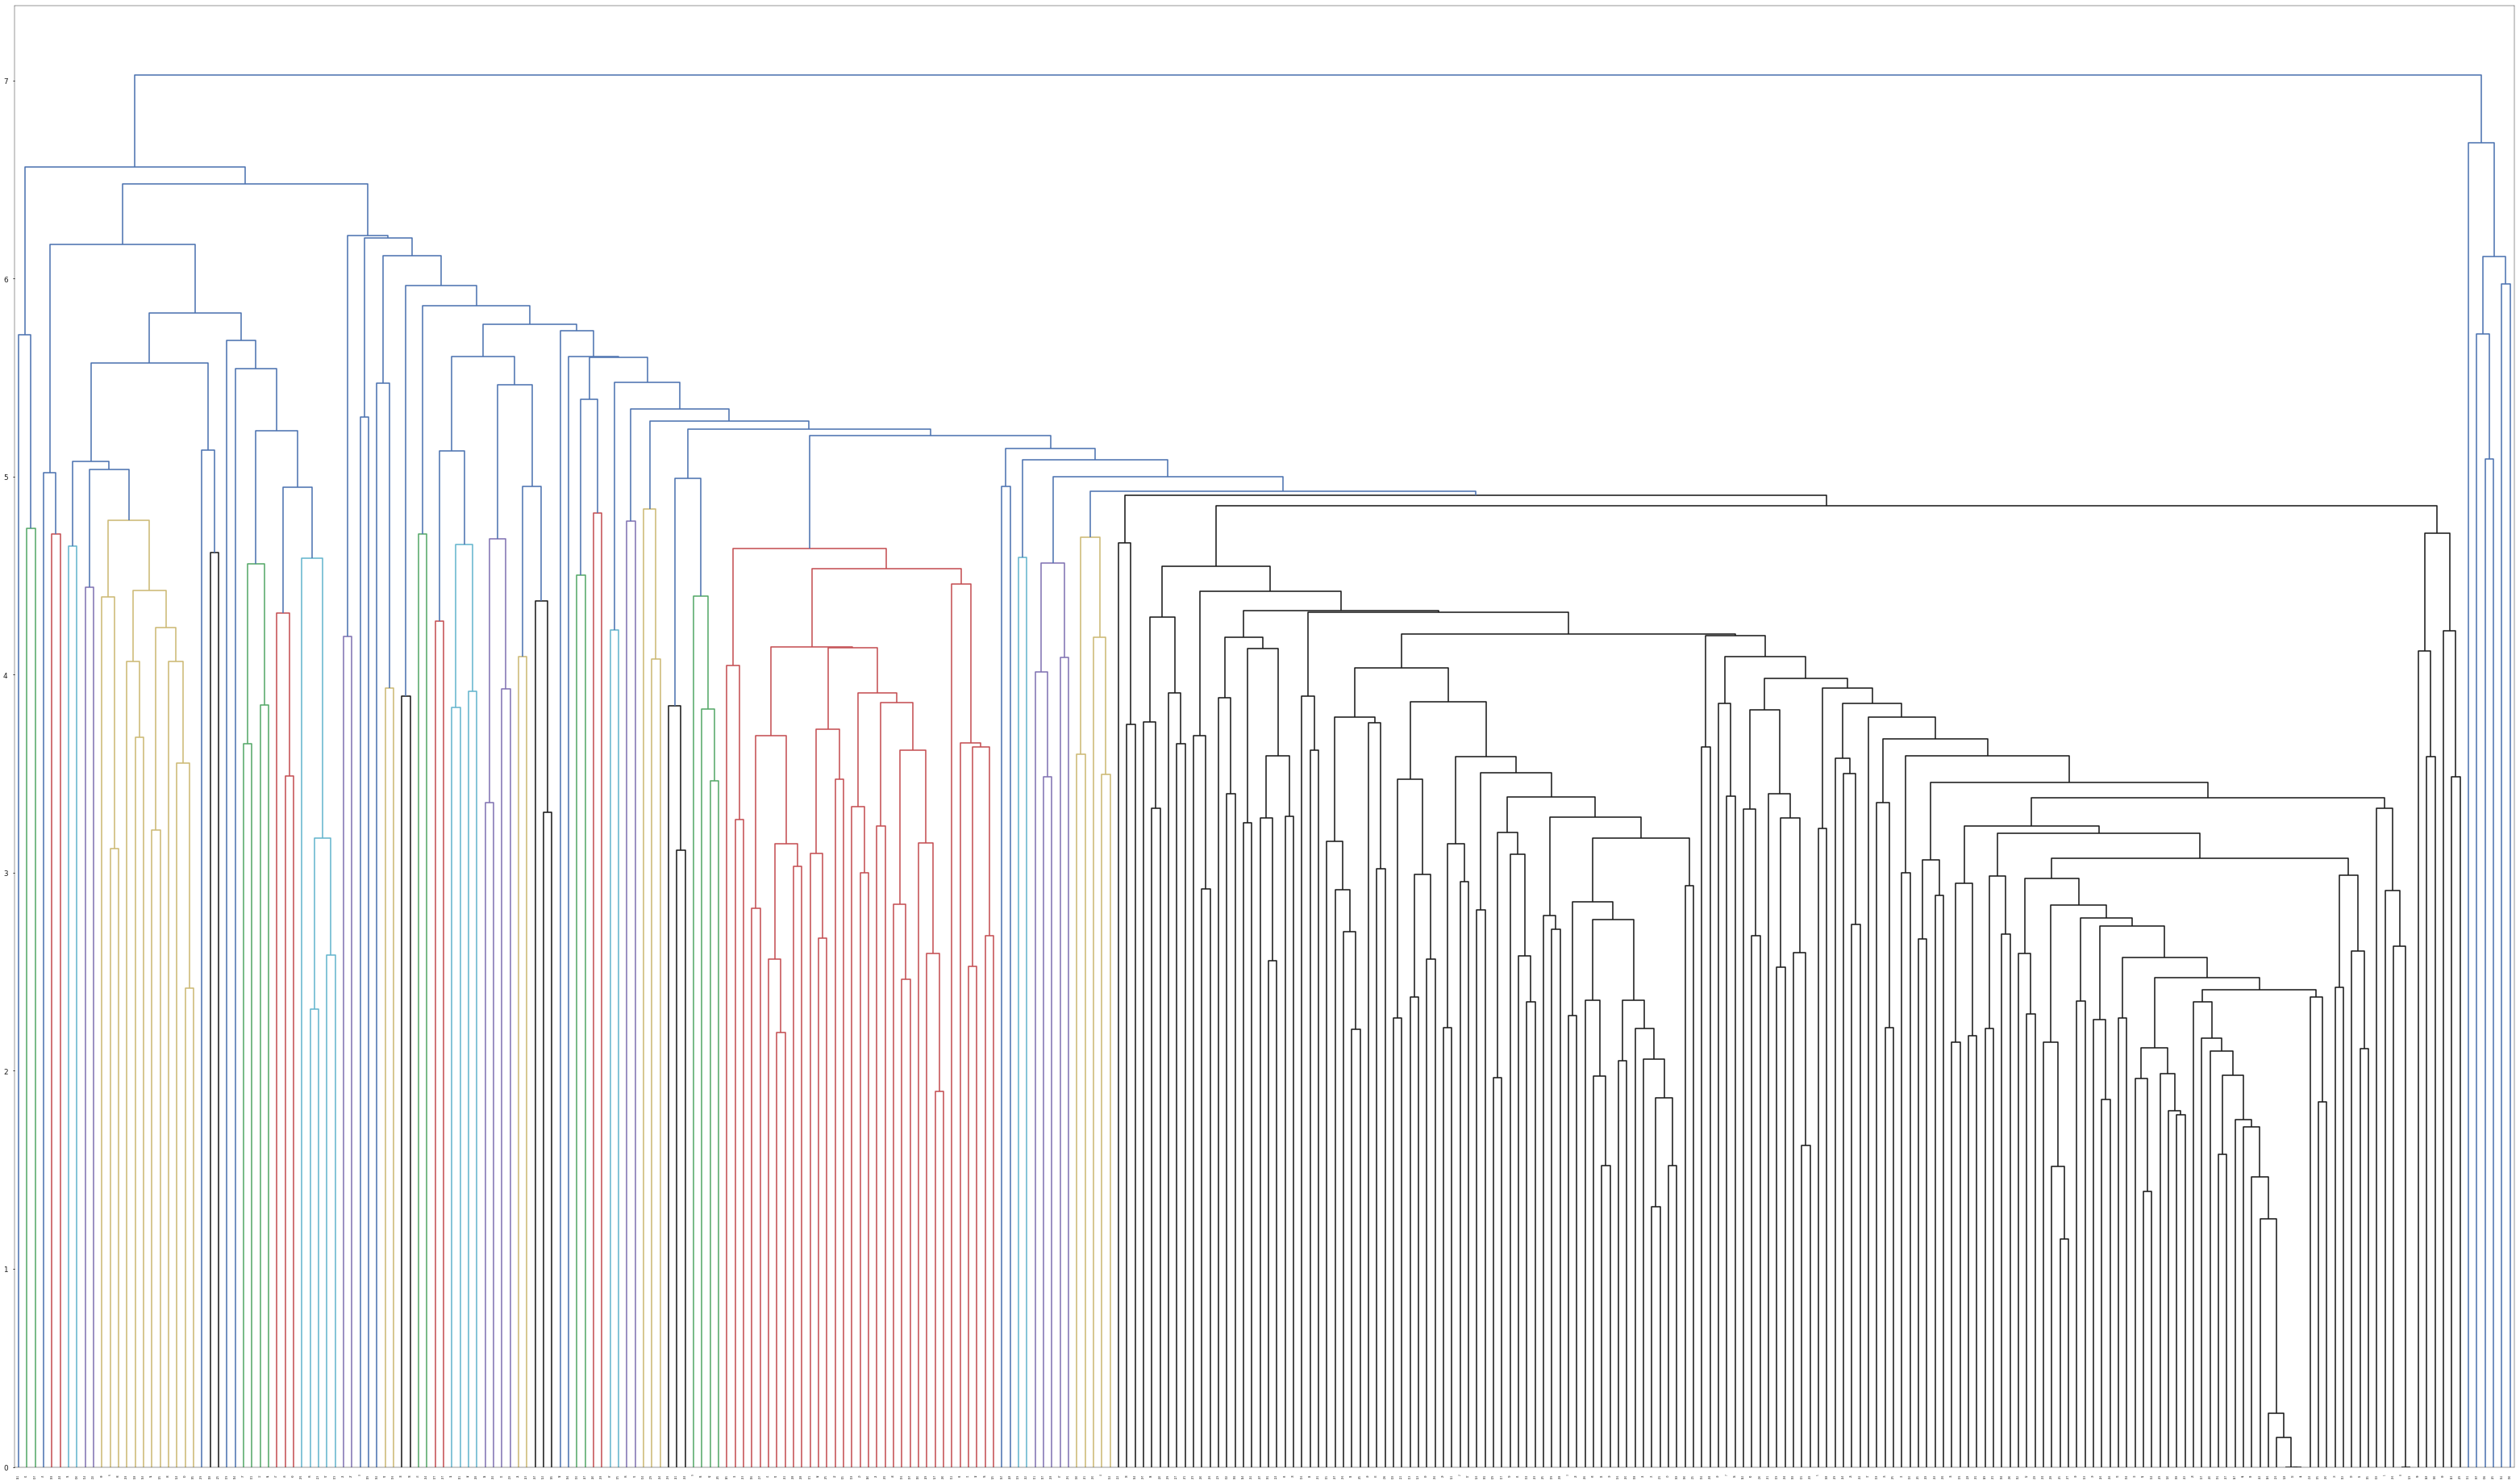

Panini Bread and Grill,4129 E Van Buren St, Ste 105,Phoenix,AZ
El Chorro,5550 E Lincoln Dr,Paradise Valley,AZ
Sorso Wine Room,15323 N Scottsdale Rd, Ste 150,Scottsdale,AZ
Phoenix City Grille,5816 N 16th St,Phoenix,AZ
B&R Wine - Food,7366 E Shea Blvd, Ste 112,Scottsdale,AZ
Panini Bread & Grill,3510 W Bell Rd,Glendale,AZ
Milk + Honey JCC,12701 N Scottsdale Rd,Scottsdale,AZ
SanTan Brewing Company,8 S San Marcos Pl,Chandler,AZ
Heroes Pub & Grub,5940 W Union Hills Dr,Glendale,AZ
Local Play Yard Bar & Grill,3002 N Arizona Ave, Ste 1,Chandler,AZ
Karlas Sports Lounge & Restaurant,2448 Grand Ave,Phoenix,AZ
Starfire Grille,11500 N Hayden Rd,Scottsdale,AZ
CM2 Pizzeria & Bakeshop,11485 N 136th St,Scottsdale,AZ
Perfect Pear Bistro,1241 E Chandler Blvd,Phoenix,AZ
Helio Basin Brewing,3935 E Thomas Rd,Phoenix,AZ
Spoke & Wheel,8525 N Central Ave,Phoenix,AZ
Carly's Bistro,128 E Roosevelt St,Phoenix,AZ
Local Jonny's,6033 E Cave Creek Rd,Cave Creek,AZ
The Upton,7216 E Shoeman Ln,Scottsdale,AZ
Hit Ratio:  

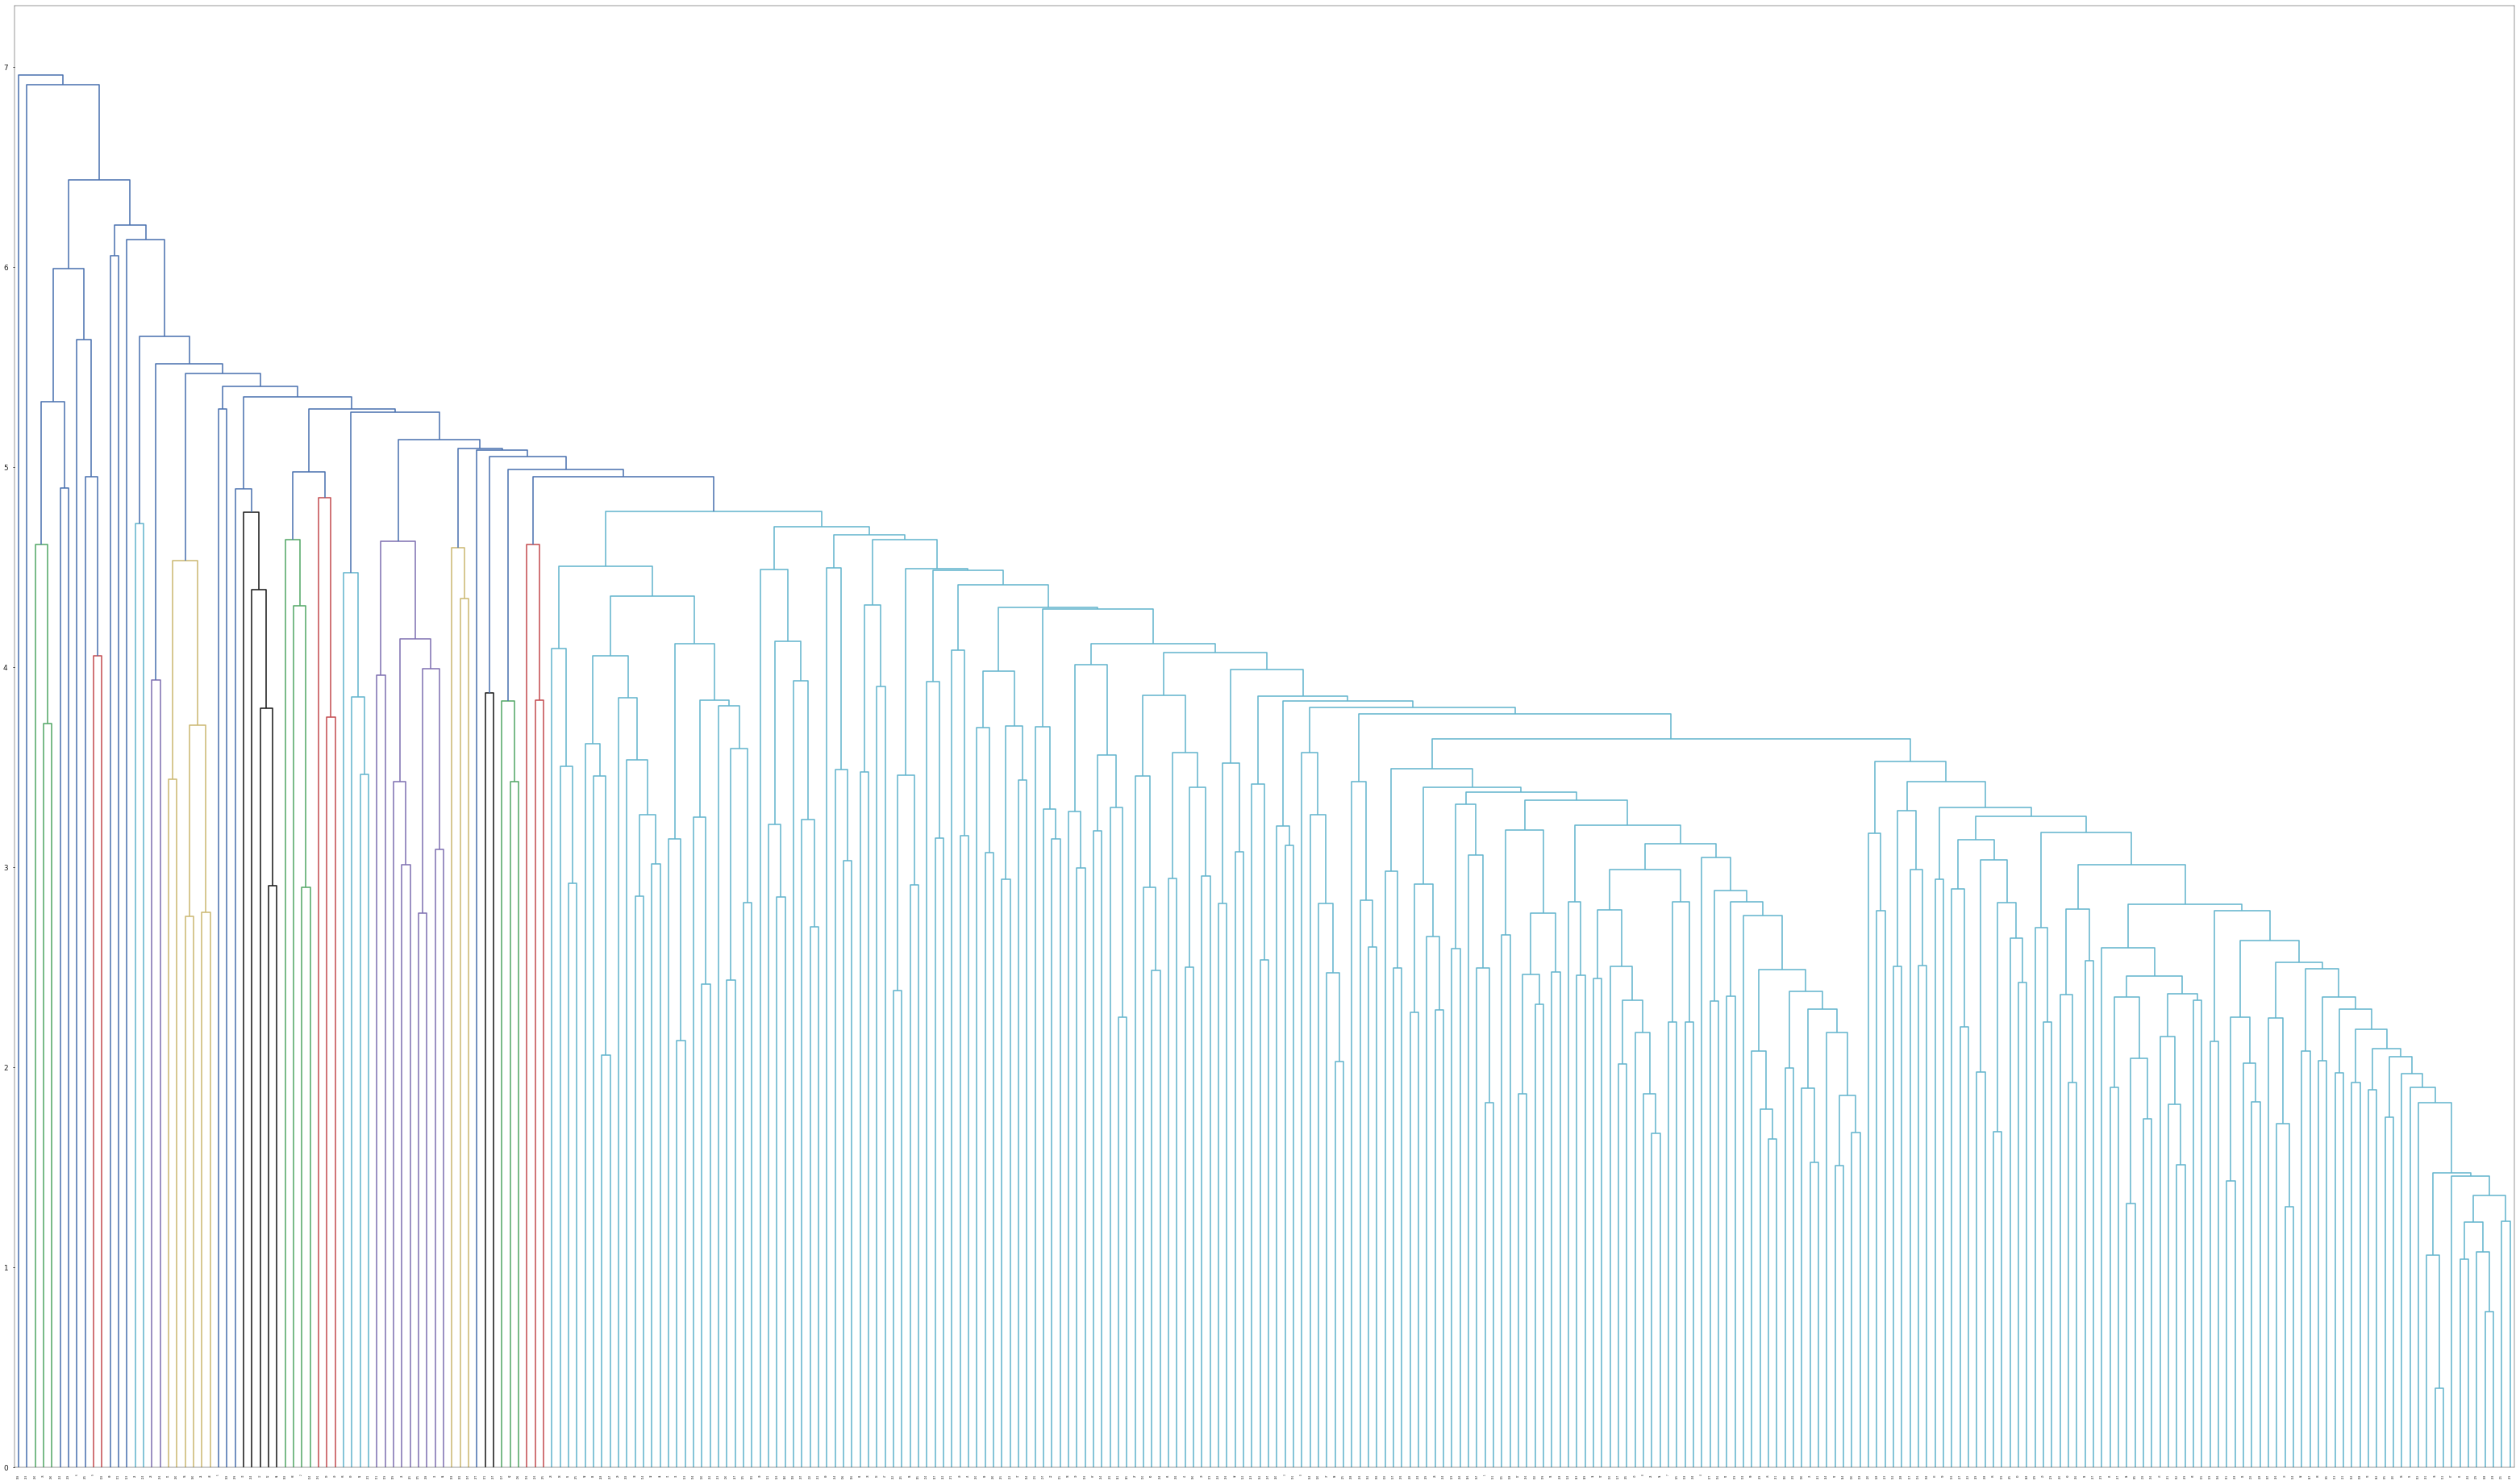

Bar Sixty,60 Bathurst Street,Toronto,ON
MoTo Coffee and Snack Bar,1321 Dundas Street W,Toronto,ON
Haute Coffee,153 Dupont Street,Toronto,ON
Zona Caffe,9401 Jane Street, Suite 119,Vaughan,ON
Scout & Cash Caffe,146 Christie Street,Toronto,ON
Voodoo Child,388 College Street,Toronto,ON
Page One,106 Mutual Street,Toronto,ON
The Porch Light,982 Kingston Road,Toronto,ON
Ciao Europa Cafe,80 Western Battery Road,Toronto,ON
Northwood,815 W Bloor Street,Toronto,ON
Tatlows Broiler Bar,380 Queensville Side Road W,River Drive Park,ON
Raca Cafe and Bar,1704 Queen Street W,Toronto,ON
Tim Horton,910 Lakeshore Road E,Mississauga,ON
Limelite Cafe,8540 Keele Street,Vaughan,ON
Paint Cabin,723 Gerrard Street E,Toronto,ON
Tesla Cafe,690 Euclid Avenue,Toronto,ON
Bannock,401 Bay Street,Toronto,ON
Film Cafe by Eative,230 Augusta Avenue,Toronto,ON
Sugar For My Honey,3399 Lake Shore Boulevard,Toronto,ON
Hit Ratio:  0.561403508772
NDCG:  0.837091481179





Recommendation info summary for :  NV
number of valid use

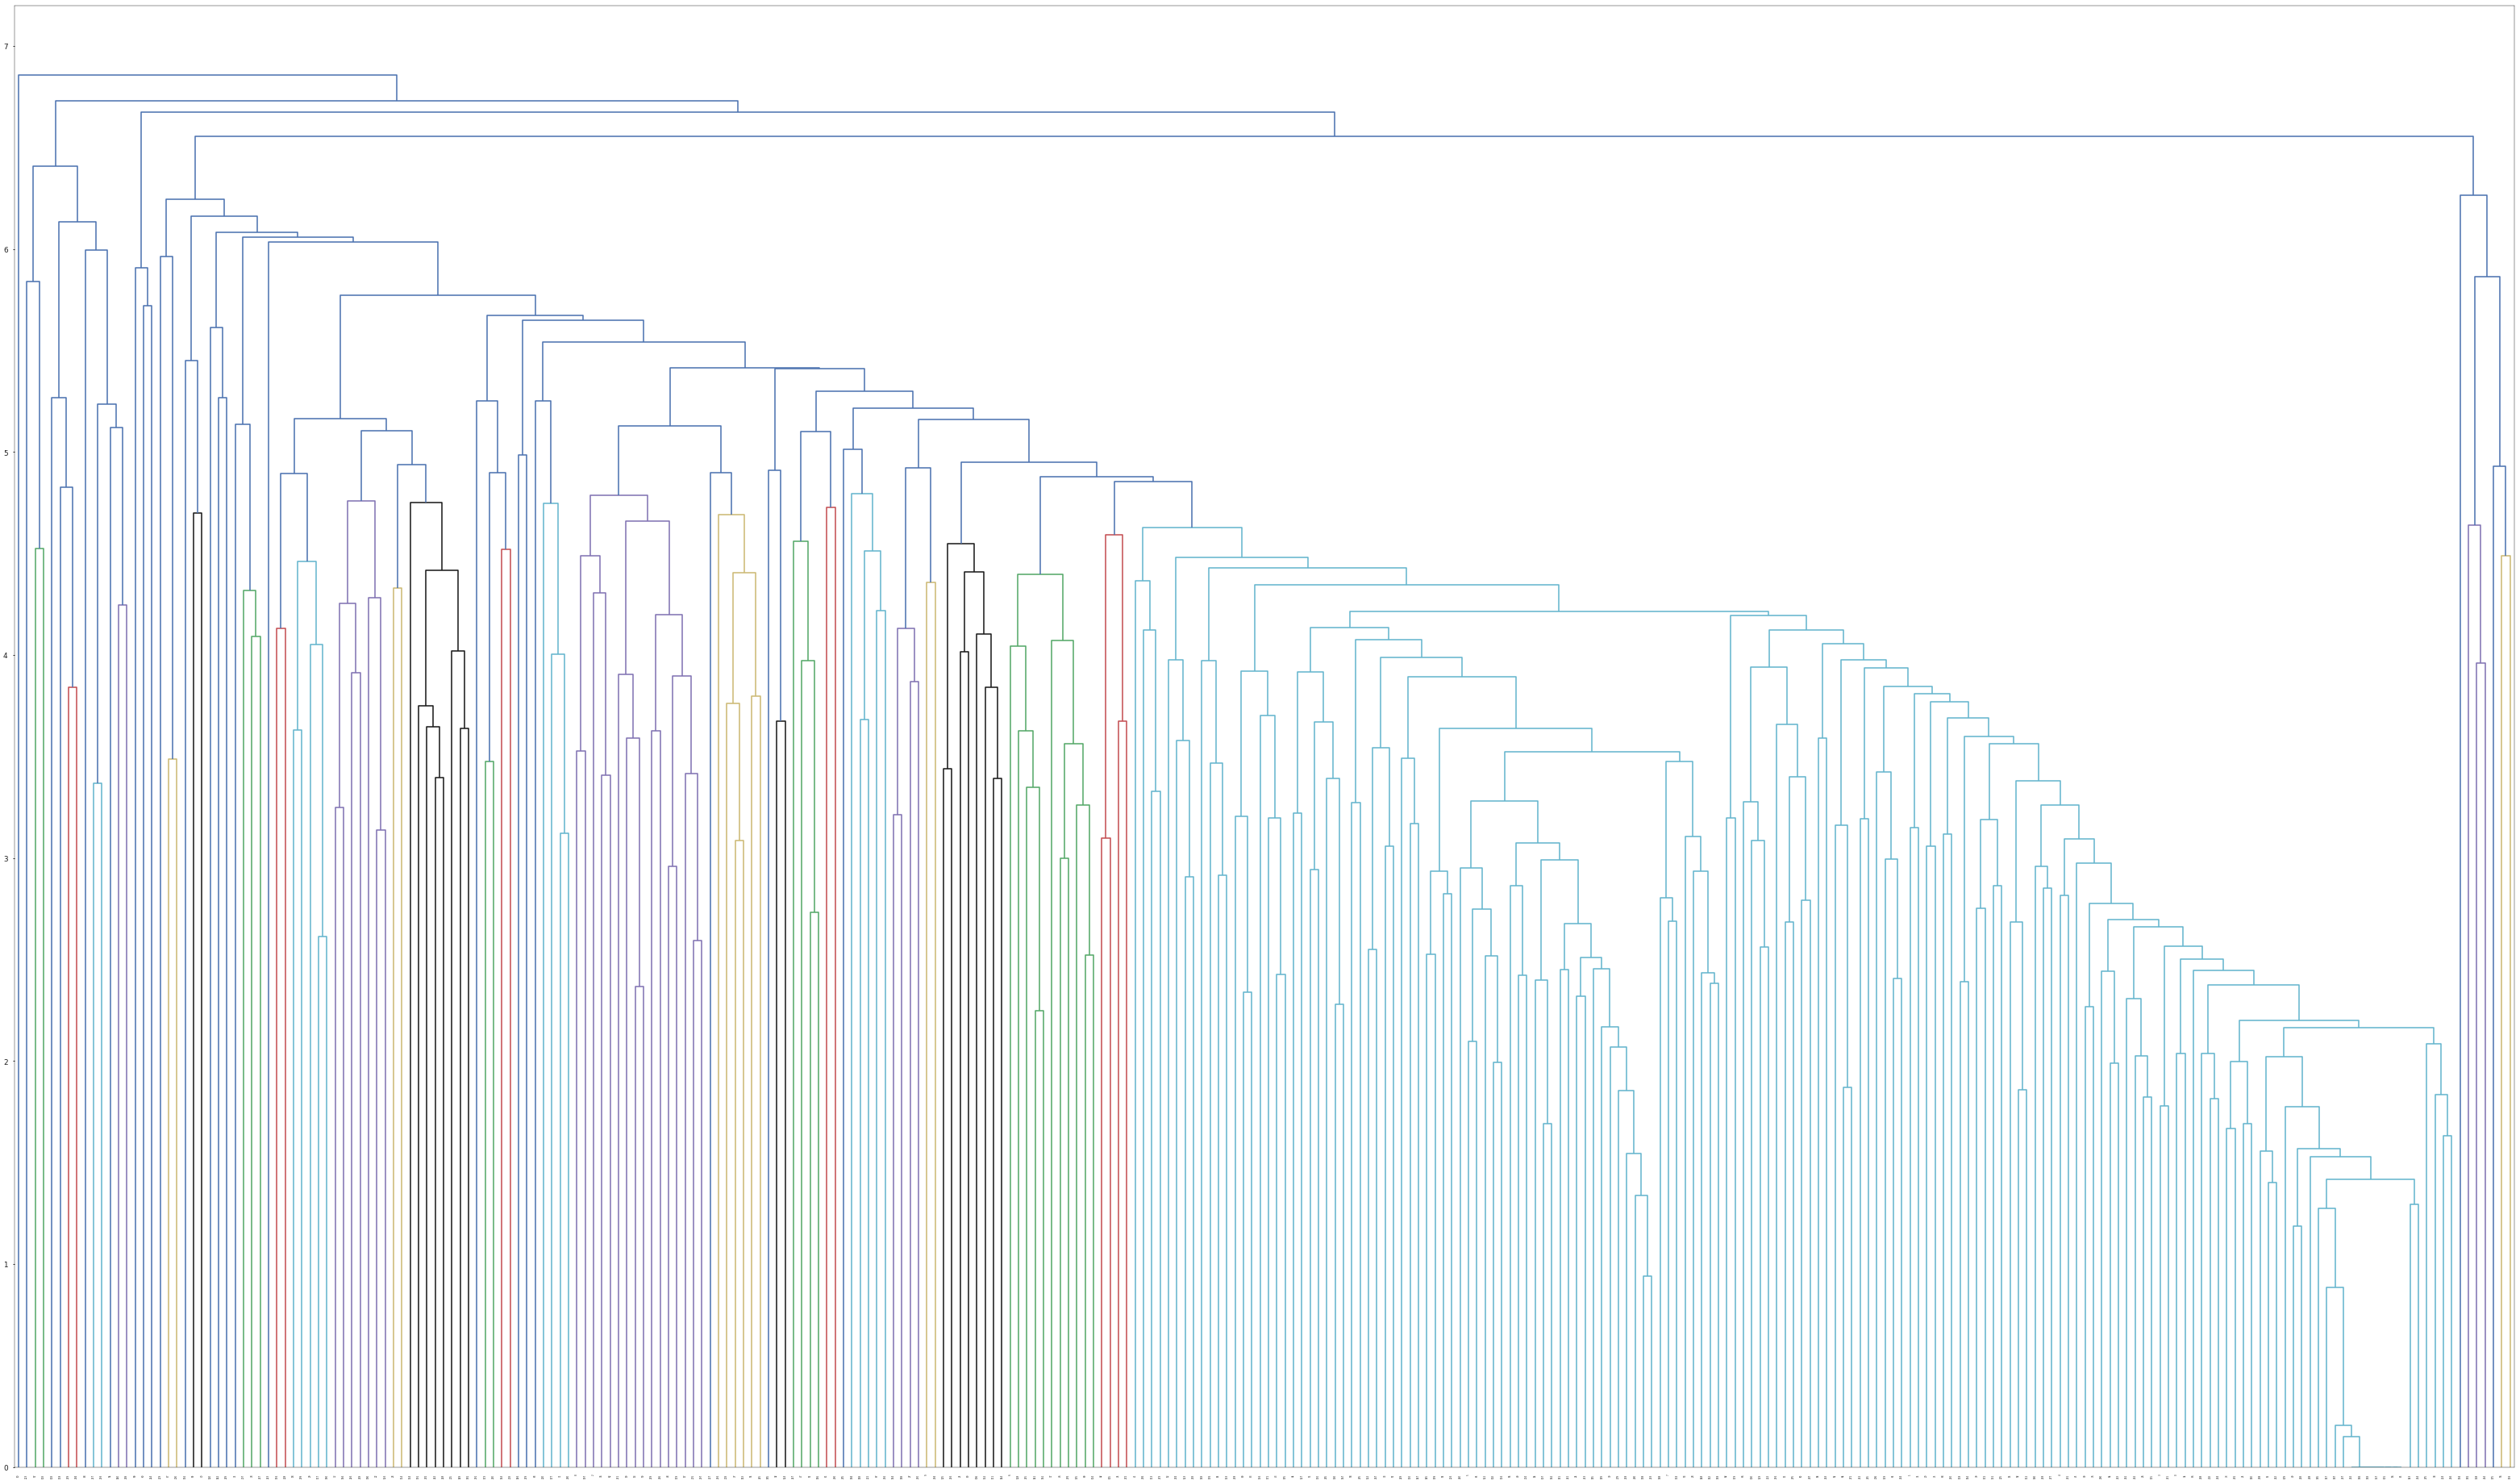

Yard House,11011 W Charleston Blvd,Las Vegas,NV
Greens and Proteins,8975 S Eastern Ave,Las Vegas,NV
Jjanga Steak & Sushi,6125 S Fort Apache Rd, Ste 200,Las Vegas,NV
Served,1770 W Horizon Ridge, Ste 100,Henderson,NV
KIT's Kitchen,2021 W Sunset Rd,Henderson,NV
Gilligan's HideAway,2601 Atlantic St,Las Vegas,NV
Zest - Bistro & Bar,10670 Southern Highlands Pkwy, Ste 102,Las Vegas,NV
Yard House,6593 Las Vegas Blvd S,Las Vegas,NV
Yard House,3545 Las Vegas Blvd,Las Vegas,NV
Pier 215,7060 S Durango Dr, Ste 101,Las Vegas,NV
Espression Cafe,321 S Casino Center Blvd, Ste 120,Las Vegas,NV
Soho Sushi Burrito,6040 W Badura Ave, Ste 150,Las Vegas,NV
Standard & Pour,11261 S Eastern Ave, Ste 200,Henderson,NV
The Blind Pig,4515 Dean Martin Dr, Ste 1,Las Vegas,NV
Grotto Ristorante,129 E Fremont St,Las Vegas,NV
Elements Fine Casual Dining & Cocktails,4950 S Rainbow Blvd, Ste 100,Las Vegas,NV
Off The Strip at the LINQ,3545 Las Vegas Blvd S,Las Vegas,NV
Born And Raised,10050 S Eastern Ave,Henderson,NV
Cactus

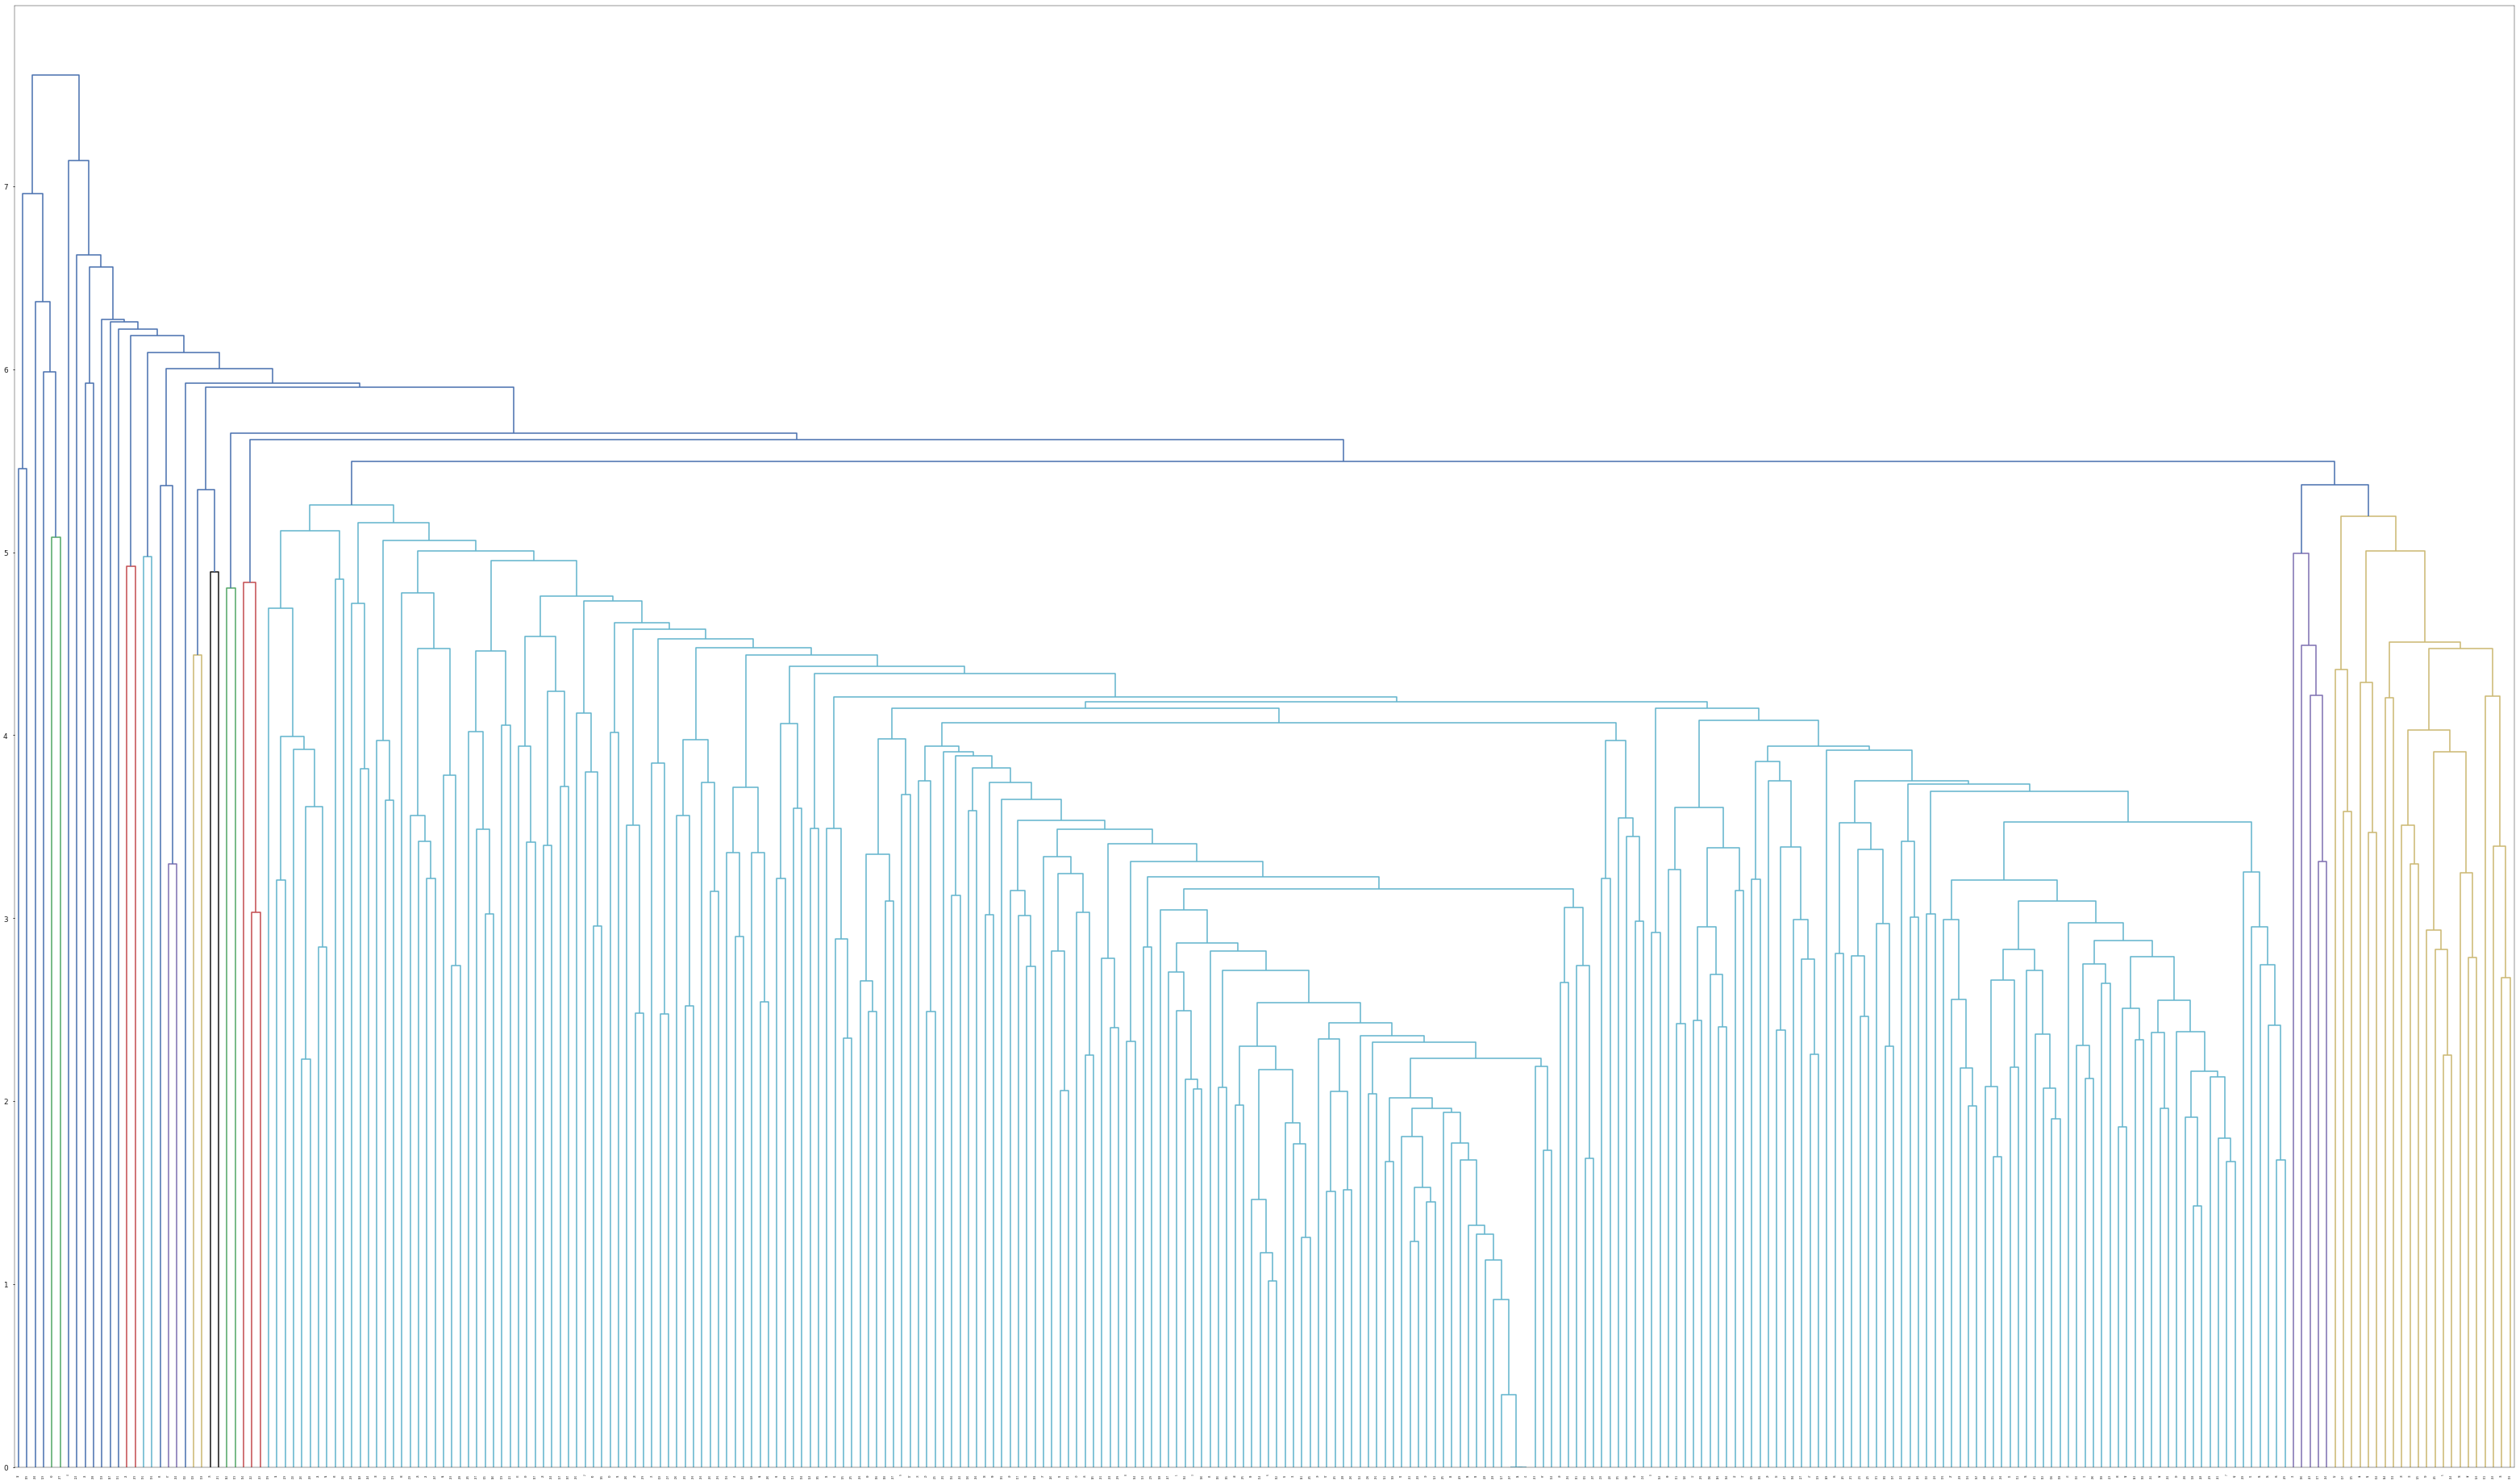

Merchant Street,2391 W 11th St,Cleveland,OH
Beer & Belly Sports Grille,158 E Aurora,Northfield,OH
Grindstone Tap House,826 Front St,Berea,OH
The Fix Bistro,2195 Lee Rd,Cleveland Heights,OH
Rowley Inn,1104 Rowley Ave,Cleveland,OH
The Jailhouse Taverne,15478 Avon Belden Rd,Grafton,OH
Manhattan Deli Bar & Grille,34601 Ridge Rd,Willoughby,OH
Speedys Grub Shack,14001 Lakewood Heights Blvd,Cleveland,OH
Chick-fil-A,9611 Mentor Ave,Mentor,OH
Steak 'n Shake,6880 Ridge Rd,Parma,OH
Herman's Pub & Grub,2126 Pearl Rd,Brunswick,OH
Pizza 216,401 Euclid Ave,Cleveland,OH
Hambden Country Inn,13960 Rock Creek Rd,Chardon,OH
Stevenson's Bar & Grill,800 E 200th St,Cleveland,OH
Stella Mia Ristorante,28751 Center Ridge Rd,Westlake,OH
Crop Bistro,2537 Lorain Ave,Cleveland,OH
Molinari's,8900 Mentor Ave,Mentor,OH
Brio Coastal Bar & Kitchen,3265 W Market St,Fairlawn,OH
A Bar and Kitchen,850 Euclid Ave, Ste 110,Cleveland,OH
Hit Ratio:  0.607142857143
NDCG:  0.865019701508





Recommendation info summary for :  PA

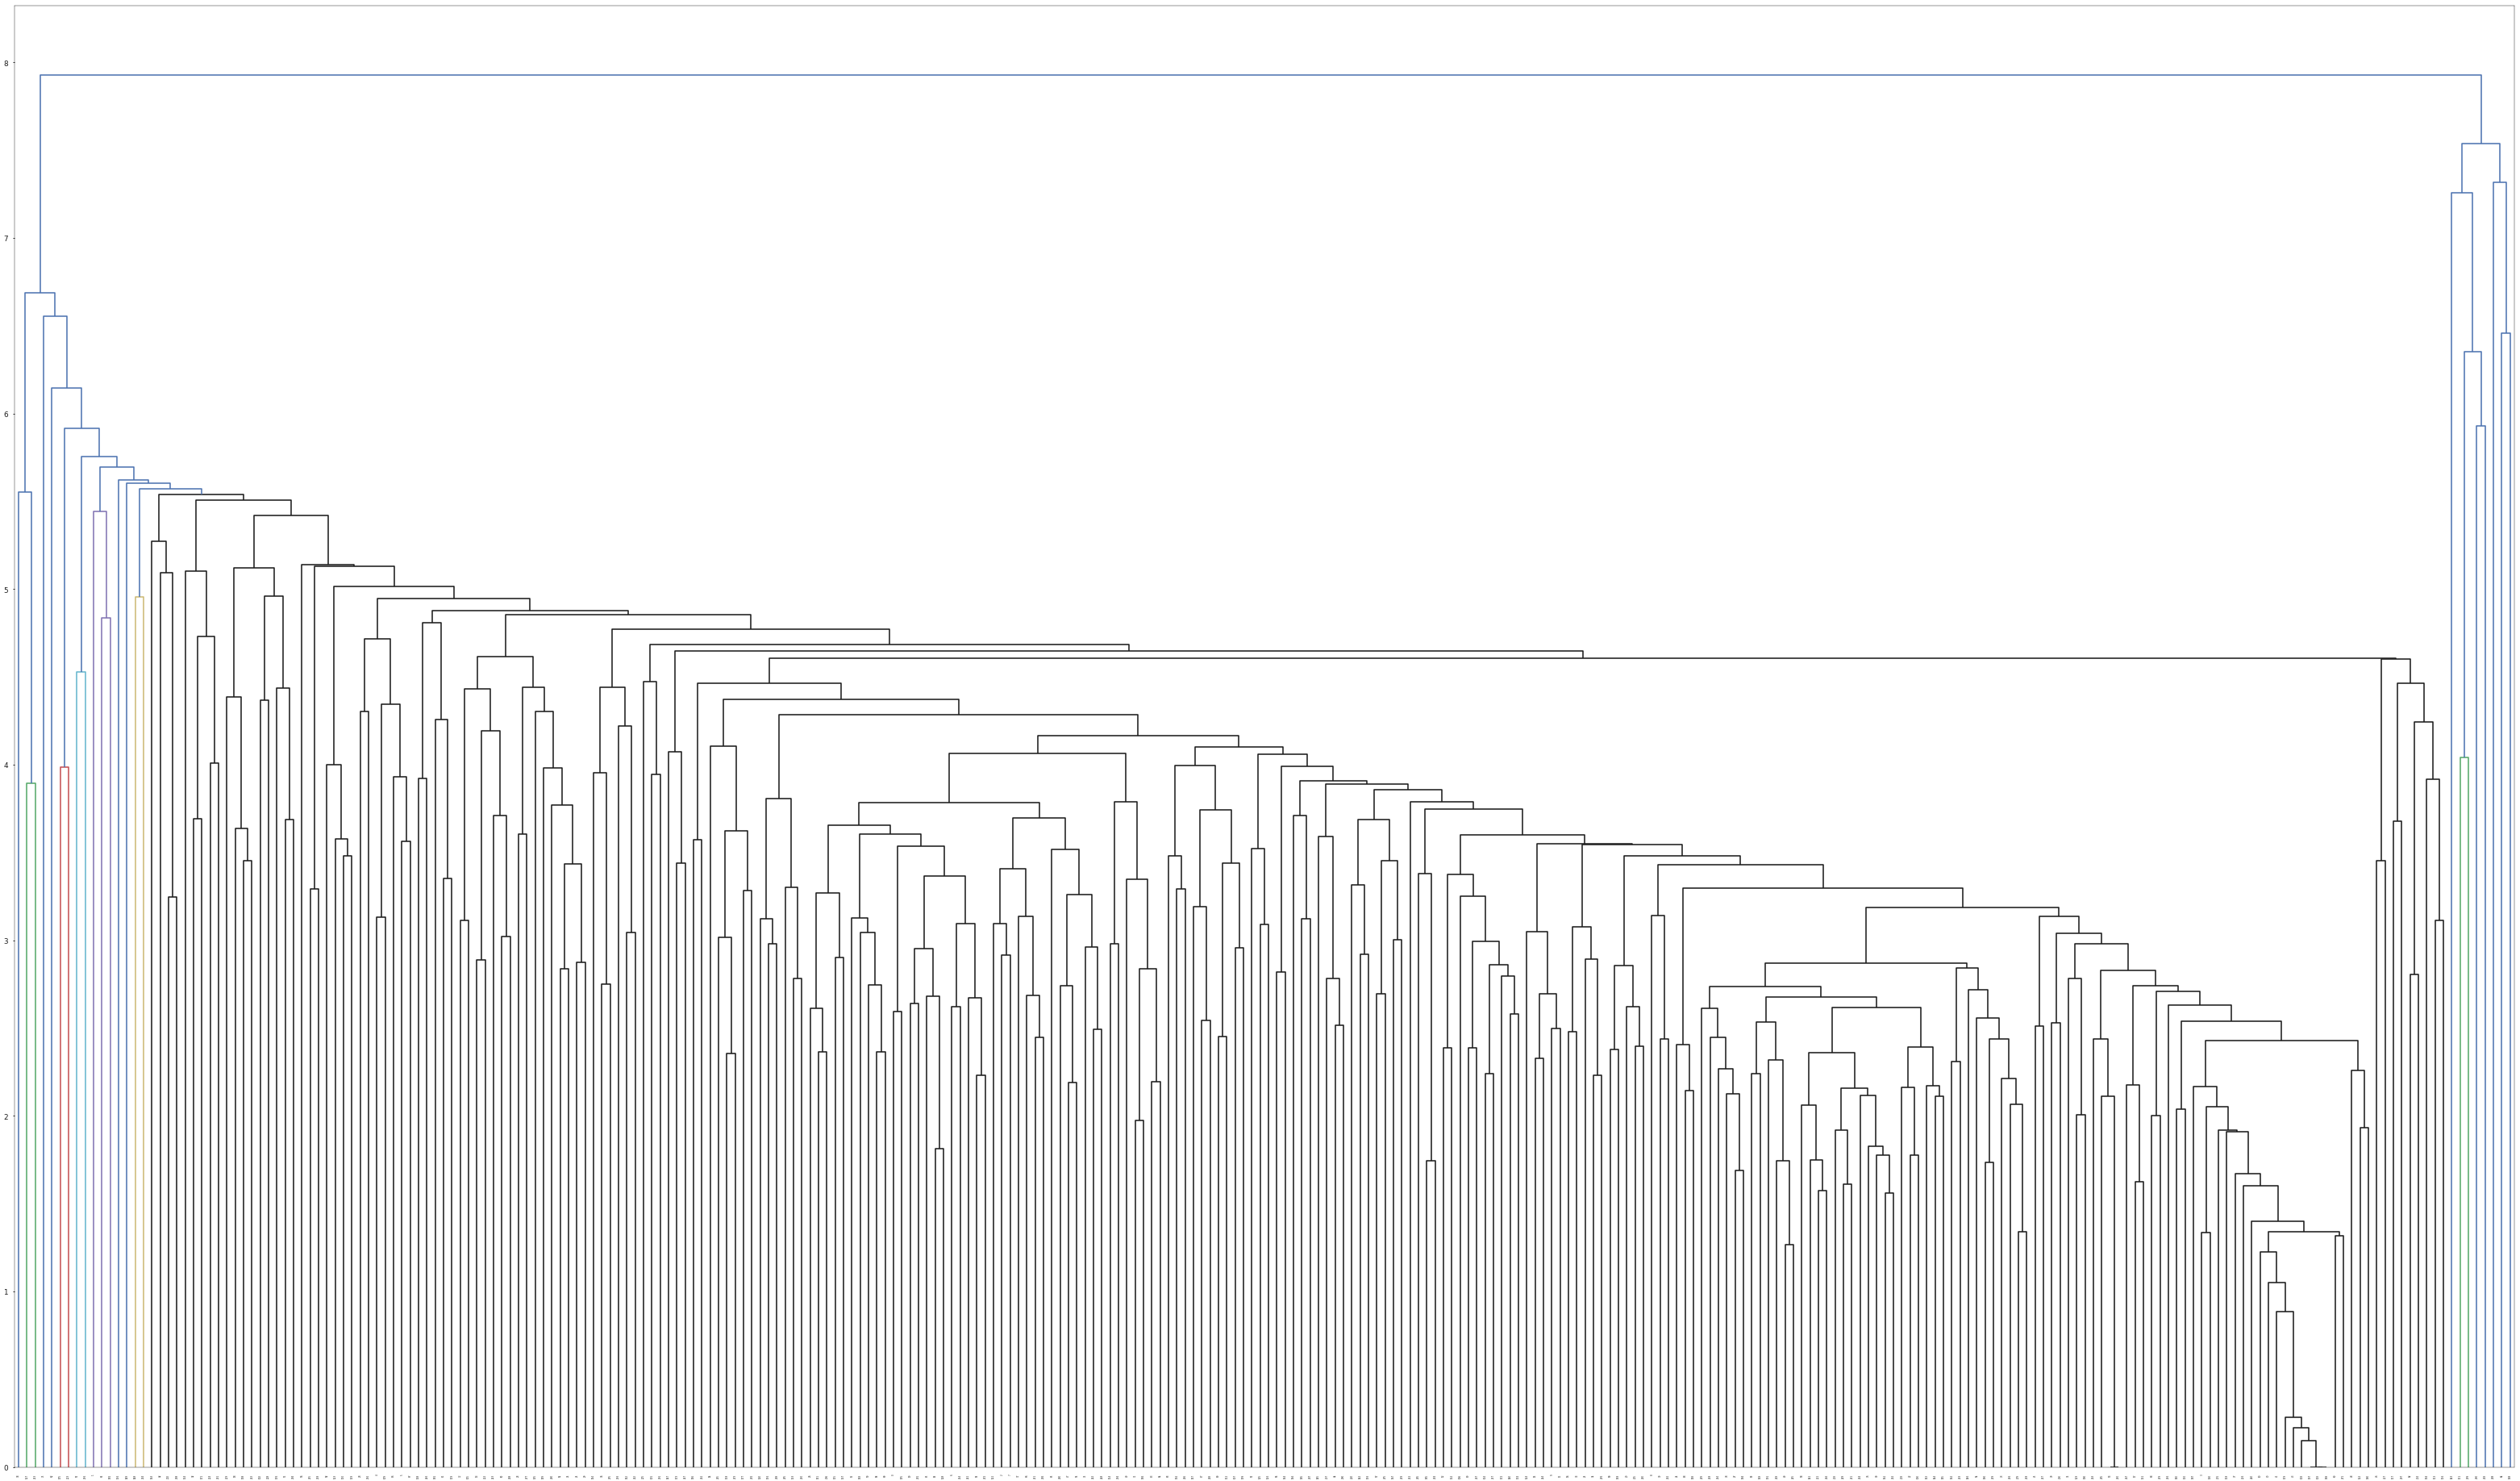

DaBuzis,3547 Washington Ave,Finleyville,PA
Atria's,1374 Freeport Rd,Pittsburgh,PA
Smallman Galley,54 21st St,Pittsburgh,PA
Mixtape,4907 Penn Ave,Pittsburgh,PA
ACE Hotel Pittsburgh,120 S Whitfield St,Pittsburgh,PA
Emporio: A Meatball Joint,11978 Perry Hwy,Wexford,PA
Duss Ave Cafe,1811 Duss Ave,Ambridge,PA
Bishop's Corner Café,4701 Campbells Run Rd,Pittsburgh,PA
Market Street Grocery,435 Market St,Pittsburgh,PA
Legends Eatery,500 E N Ave,Pittsburgh,PA
The Vandal,4306 Butler St,Pittsburgh,PA
Atria's,10 Old Clairton Rd,Pittsburgh,PA
K-Vay's Restaurant,2271 Mars Hill Rd,Irwin,PA
Stagioni,2104 E Carson St,Pittsburgh,PA
Altius,1230 Grandview Ave,Pittsburgh,PA
G & G Noodle Bar,535 Liberty Ave,Pittsburgh,PA
R-Time At Rene's,1030 5th Ave,East Mc Keesport,PA
Colony Café,1125 Penn Ave,Pittsburgh,PA
Atria's Restaurant,103 Federal St,Pittsburgh,PA
Hit Ratio:  0.488372093023
NDCG:  0.783483980427





Recommendation info summary for :  NC
number of valid user:  1138
number of valid test user:  1138


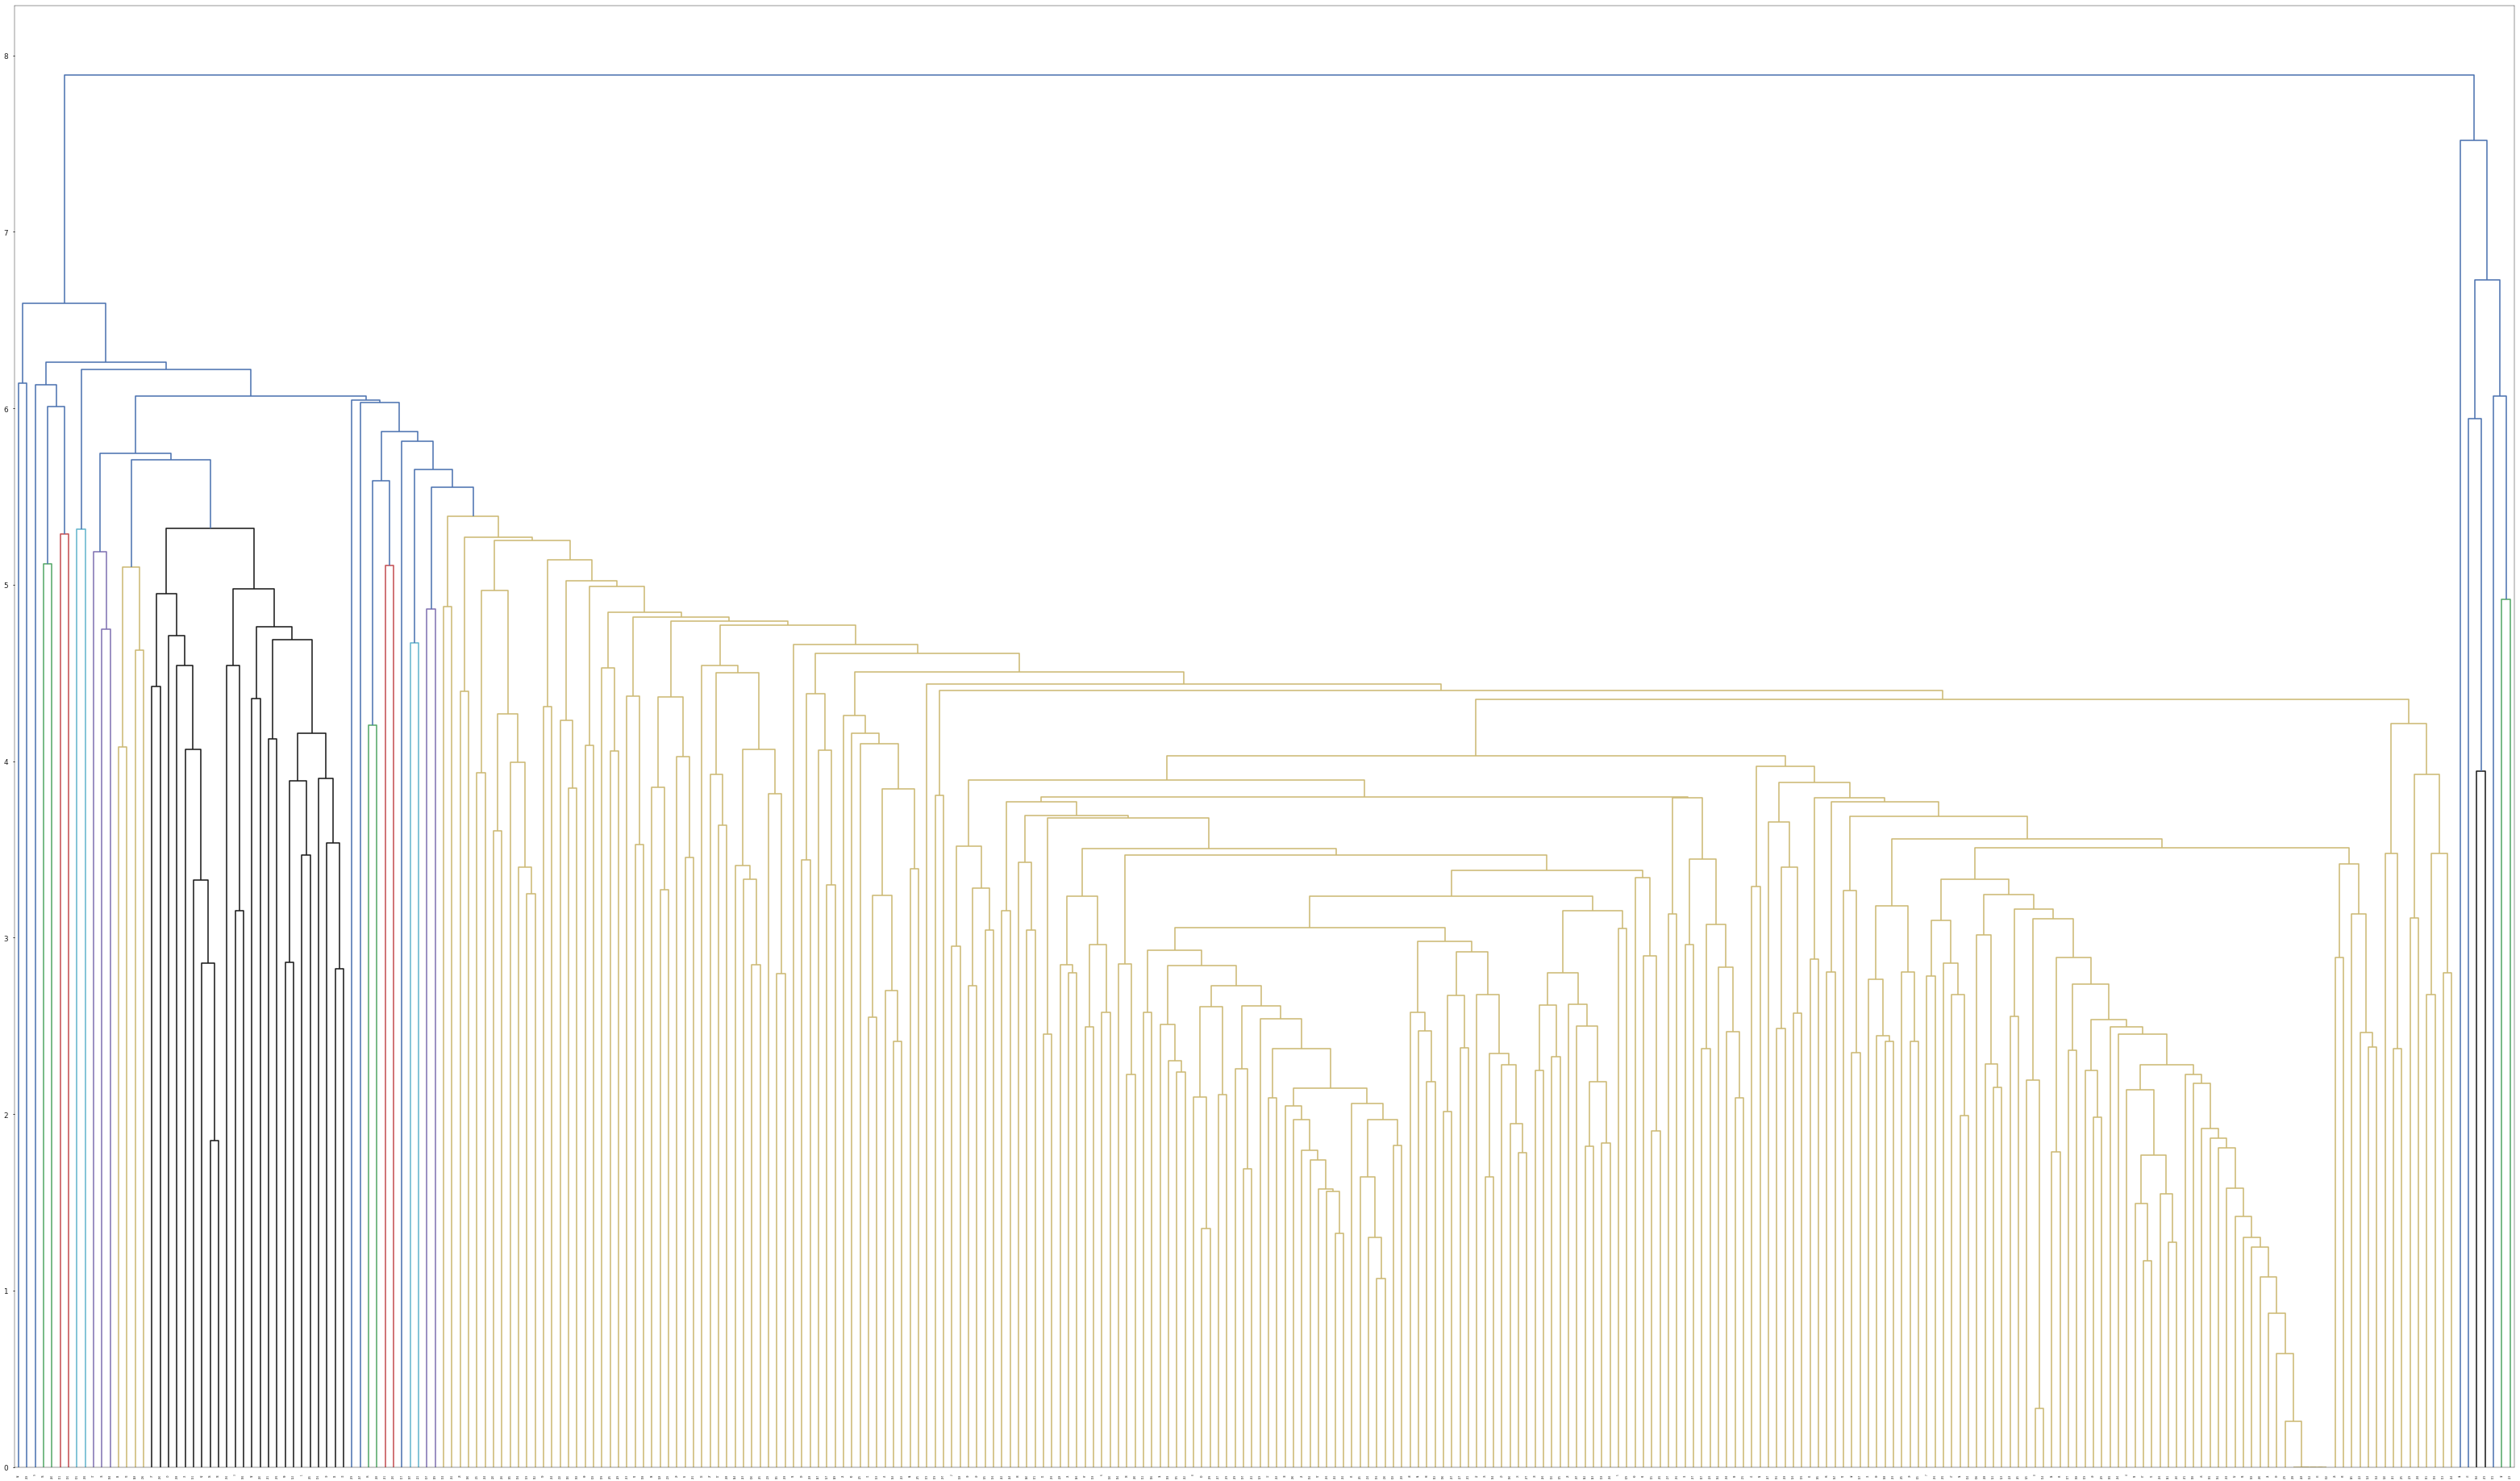

The Common Market Oakwold,4420 Monroe Rd,Charlotte,NC
Bedder Bedder & Moore Montford-Abbey,1730 Abbey Pl, Ste 4,Charlotte,NC
300 East,300 East Blvd,Charlotte,NC
49 Yardline,4539 N Carolina 49,Harrisburg,NC
Whooli's Grill,7146 E Independence Blvd,Charlotte,NC
Pineville Tavern,314 N Polk St,Pineville,NC
HoneyBaked Ham,5700 University Pointe Blvd, Suite 115,Charlotte,NC
Gallery Restaurant,10000 Ballantyne Commons Pkwy,Charlotte,NC
Artful Gourmet Carryout Catering,131 E John St,Matthews,NC
Local Loaf,224 E 7th St,Charlotte,NC
Fork!,20517 N Main St,Cornelius,NC
Moe's Original Bar B Que,111 Matthews Station St,Matthews,NC
Harry's Grille & Tavern,2127 Ayrsley Town Blvd, Ste 103,Charlotte,NC
Bad Daddy's Burger Bar,1626 East Blvd,Charlotte,NC
Pinky's Westside Grill,9818 Gilead Rd, Ste B-101,Huntersville,NC
Great Harvest Bread,1824 E Arbors Dr, Ste 390,Charlotte,NC
Chicken Salad Chick,7617-C Pineville-Matthews Rd,Charlotte,NC
Cafe South,7901 Forest Pine Dr,Charlotte,NC
Rhino Market & Deli,1500 W

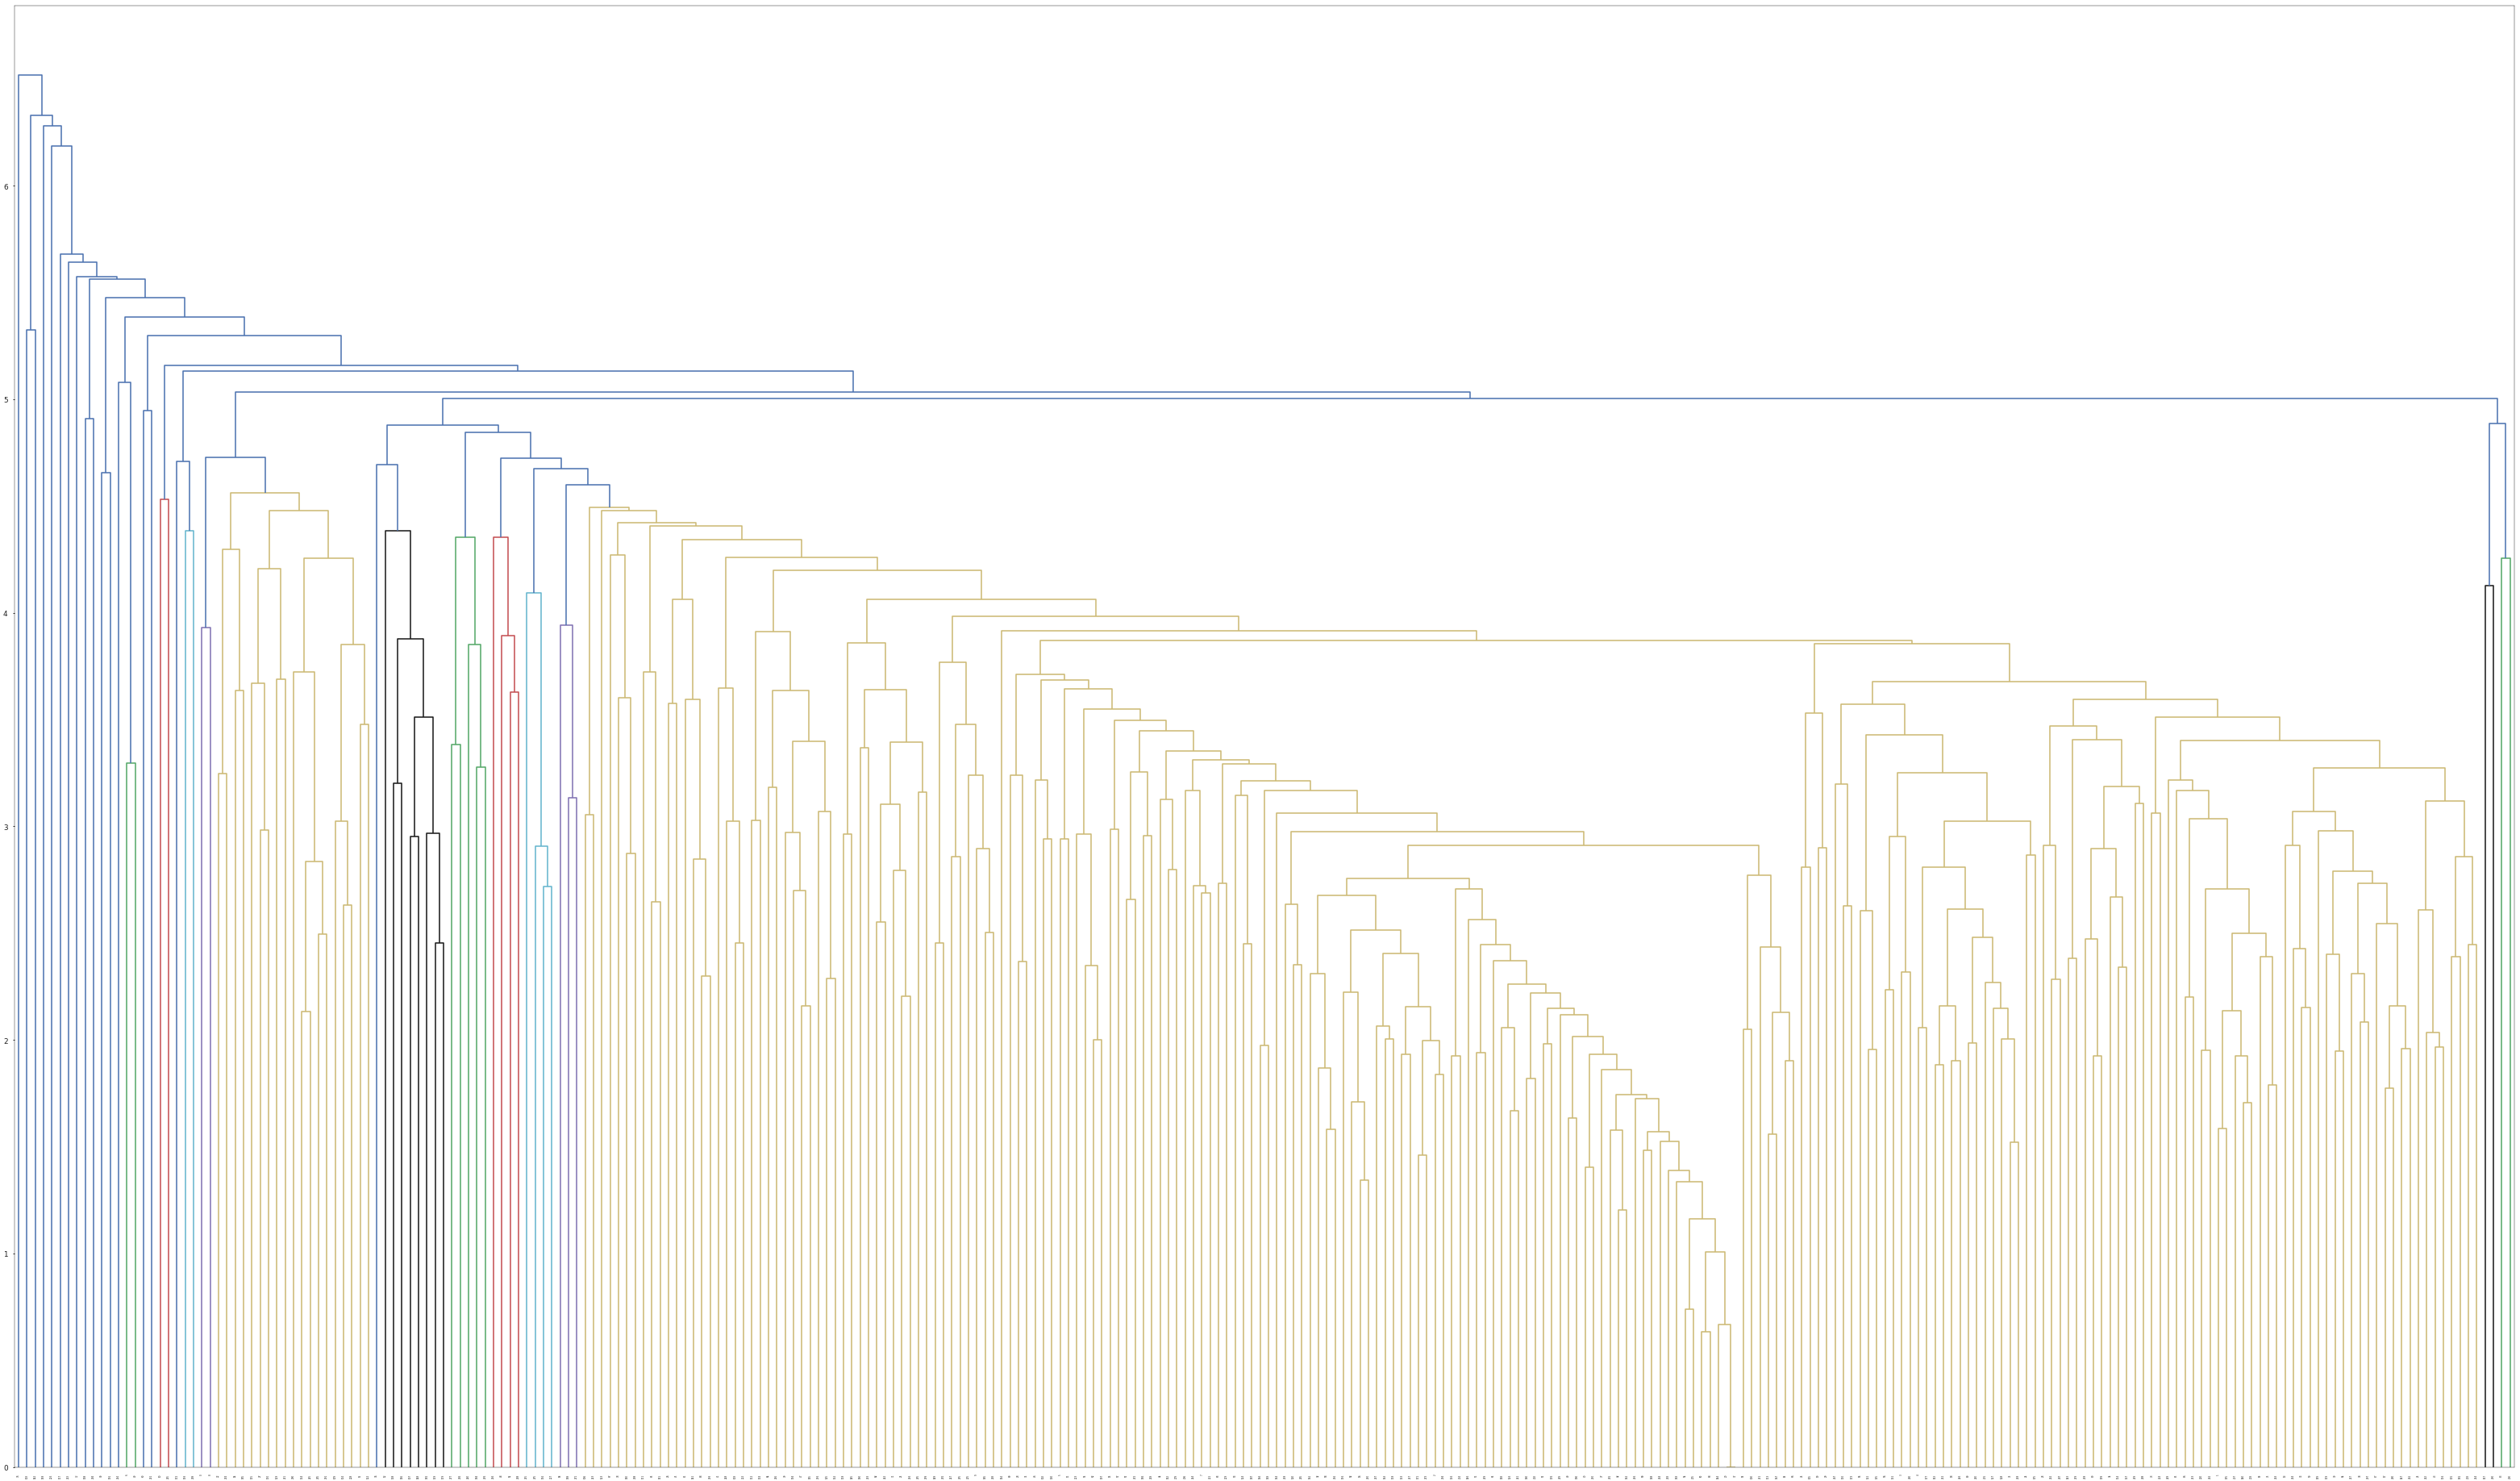

Deux - Cave à Manger,2 Rue Turgeon,Sainte-Therese,QC
Le Petit Brûloir,8485 Boulevard Saint-Laurent,Montréal,QC
Café de' Mercanti,350 Rue Notre-Dame Est,Montréal,QC
Novanta Café,90 Avenue Laurier O,Montréal,QC
Tommy,200 Rue Notre-Dame O,Montréal,QC
L'Gros Luxe Plateau,3807 Rue Saint-André,Montréal,QC
Café Parvis,433 Rue Mayor,Montréal,QC
Le Ballpark,6660 Rue Clark,Montréal,QC
La Rouladerie,1205 Avenue Bernard,Montréal,QC
Café Tuyo,370 Rue Marie-Anne,Montréal,QC
Le Majestique,4105 Boulevard Saint-Laurent,Montréal,QC
Farine,102 Saint-Viateur Ouest,Montréal,QC
Auberge du Dragon Rouge,8870 Rue Lajeunesse,Montréal,QC
Jatoba,1184 Place Phillips,Montréal,QC
The Rail Coal Fire Bistro,1500 Route 138,Kahnawake,QC
Yummy2Go,Métro Atwater, 3015 Boulevard de Maisonneuve Ouest,Montréal,QC
Belém Café & Yoga - L'Espace Café,4409 Boulevard Saint-Laurent,Montréal,QC
Bouffe Dave Plant Food,1206 Boulevard de Maisonneuve E,Montréal,QC
Brulerie Mondor,1395 Rue Des Cascade,Saint-Hyacinthe,QC
Hit Ratio:  0.5555

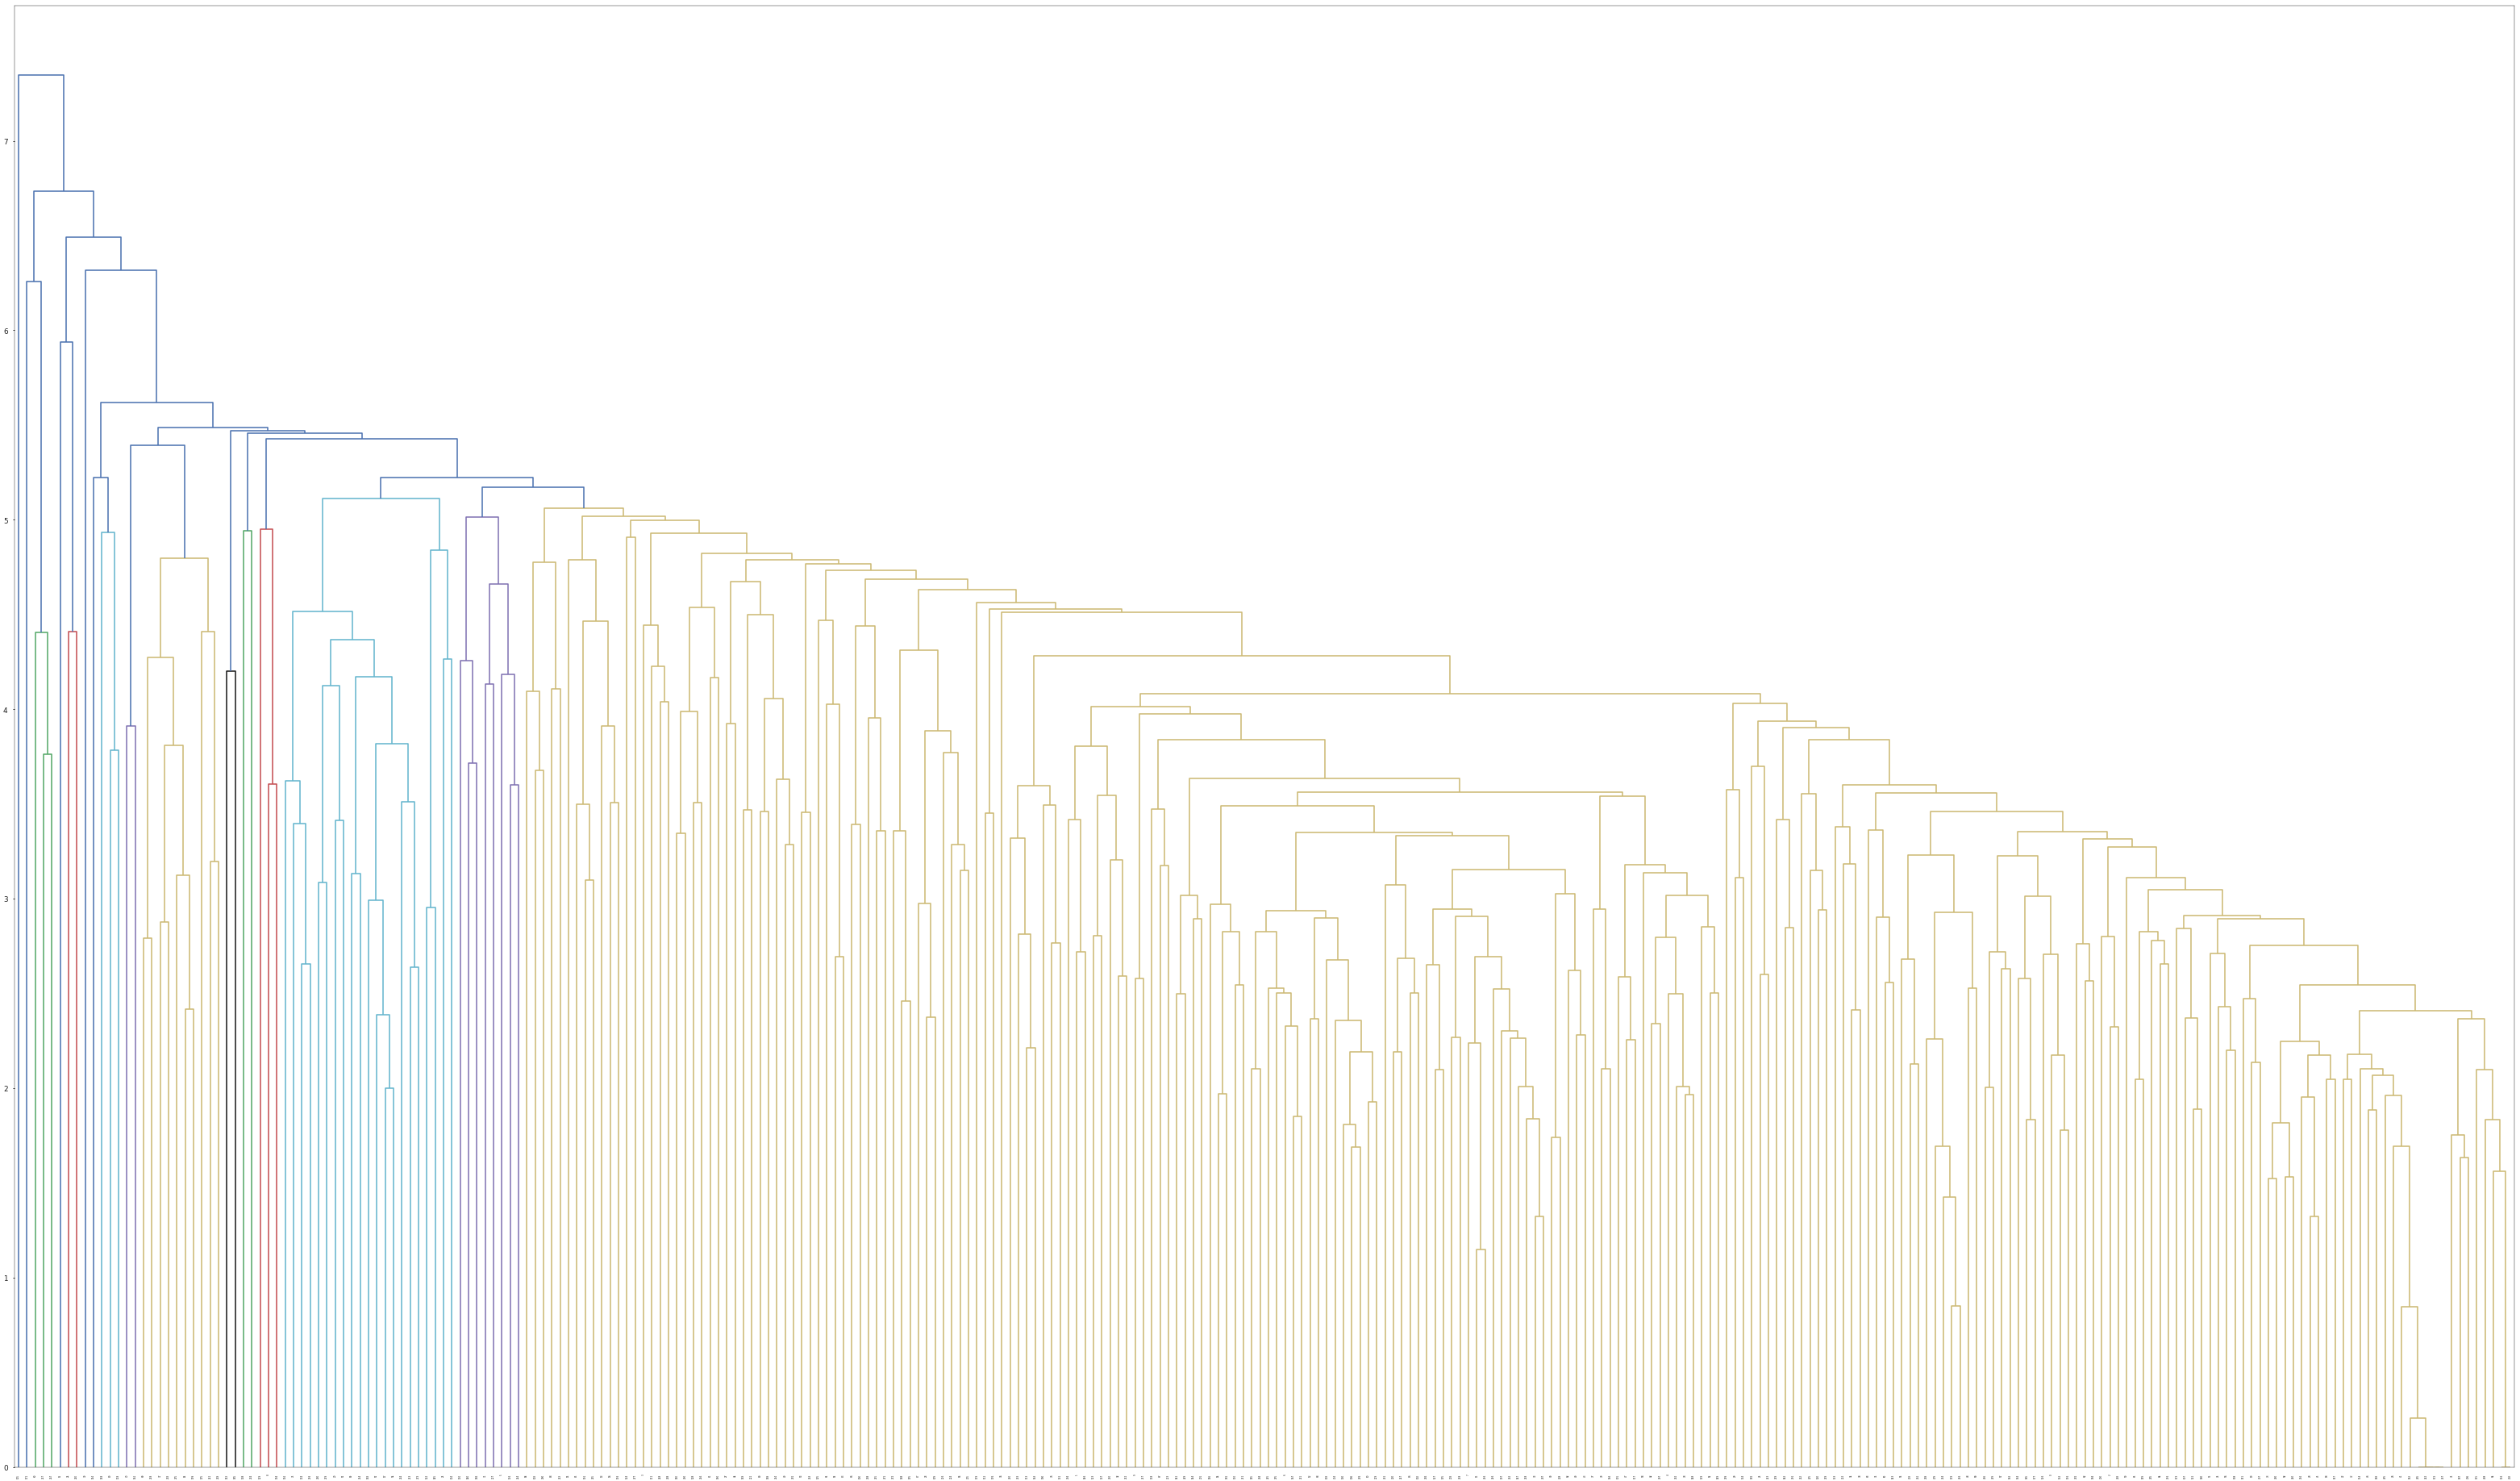

Players Sports Bar,2013 Winnebago St,Madison,WI
Casetta Kitchen and Counter,222 W Washington Ave, Ste 30,Madison,WI
Hail Mary Sports Grill,401 E Washington Ave,Madison,WI
Monte's Grill & Pub,608A W Verona Ave,Verona,WI
The Old Fashioned,23 N Pinckney St,Madison,WI
Johnson Public House,908 E Johnson St,Madison,WI
Brothers Three Bar & Grill,614 N Fair Oaks Ave,Madison,WI
The Great Dane,123 E Doty St,Madison,WI
Merchant Madison,121 S Pinckney St,Madison,WI
The Waypoint Public House,320 W Broadway,Monona,WI
Der Rathskeller,800 Langdon St,Madison,WI
Mickey's Tavern,1524 Williamson St,Madison,WI
Ski's Saloon,100 W Main St,Sun Prairie,WI
Manna Cafe & Bakery,611 N Sherman Ave,Madison,WI
Macchiatos Coffee & Wine Bar,605 S Main St,DeForest,WI
Sí Café,117 S Pinckney St,Madison,WI
Highland Espresso Bar,45 S Bassett St,Madison,WI
The Lone Girl Brewing Company,114 E Main St, Ste 101,Waunakee,WI
Glass Nickel Pizza,5003 University Ave, Ste 170,Madison,WI
Hit Ratio:  0.568181818182
NDCG:  0.75838766719

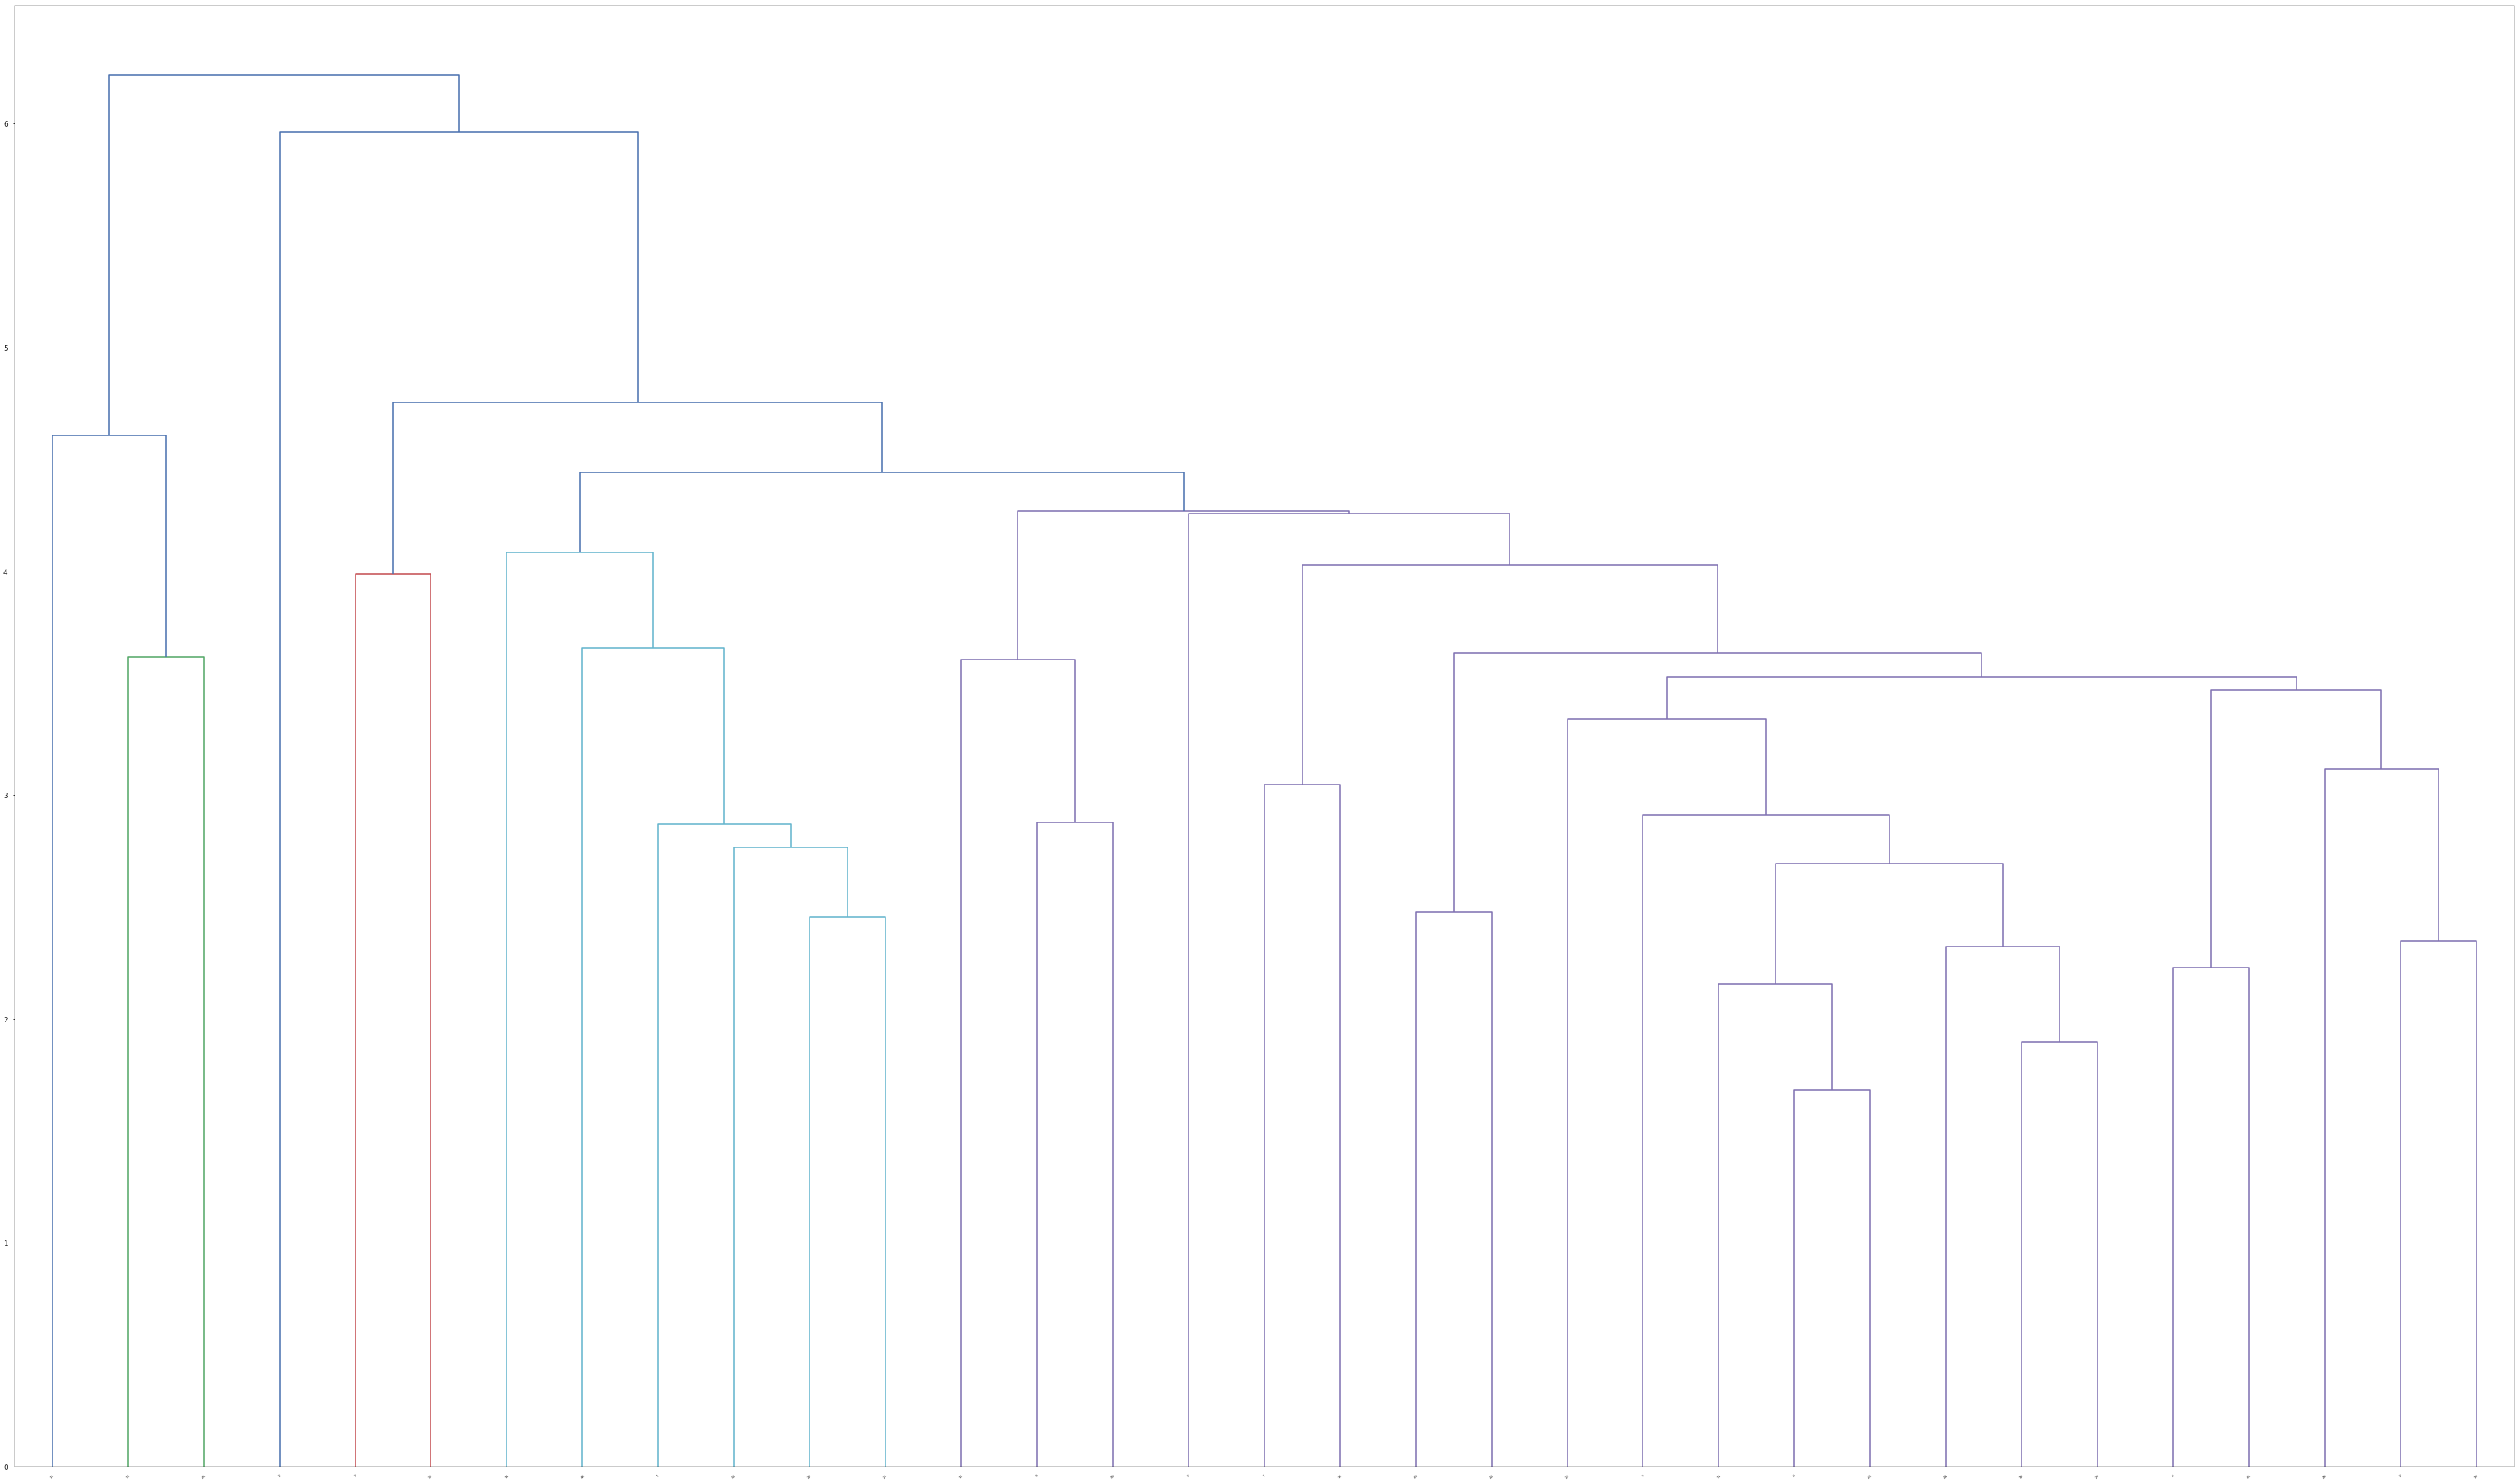

Hotel Restaurant Hirsch,Hindenburgstr. 1,Leonberg,BW
Da Enzo Ristorante E Pizzeria,Im Dietbach 3,Fellbach,BW
Punto fisso,Christophstr. 14,Stuttgart,BW
Wein-Musketier,Julius-Hölder-Str. 29 B,Stuttgart,BW
Hotel Goldener Pflug,Dorfstr. 2 - 6,Ludwigsburg,BW
Weinstube Vetter,Bopserstr. 18,Stuttgart,BW
Weinstube Am Stadtgraben,Am Stadtgraben 6,Stuttgart,BW
Schwanenbräu,Bernhäuser Hauptstr. 36,Bernhausen,BW
Orra Dönerlounge,fleischmannstr. 10,Esslingen,BW
Bar Vicino,Traubenstr. 45,Stuttgart,BW
Weinstube Lamm,Mühlstr. 24,Stuttgart,BW
Mögle,Dieterlestr. 32,Stuttgart,BW
Reiterstüble Gasthaus,Furtwänglerstr. 190,Stuttgart,BW
Stöckle,Johannesstr. 76,Stuttgart,BW
Gasthaus Grünewald,Grünewaldstr. 100,Stuttgart,BW
Zum Löwen,Stuttgarter Str. 1,Steinenbronn,BW
Malathounis,Gartenstr. 5,Kernen im Remstal,BW
Mauritius,Fronacker Str. 33 - 35,Waiblingen,BW
Amadeus Restaurant & Bar,Charlottenplatz 17,Stuttgart,BW
Hit Ratio:  1.0
NDCG:  0.8





Recommendation info summary for :  IL
number of valid user:  107

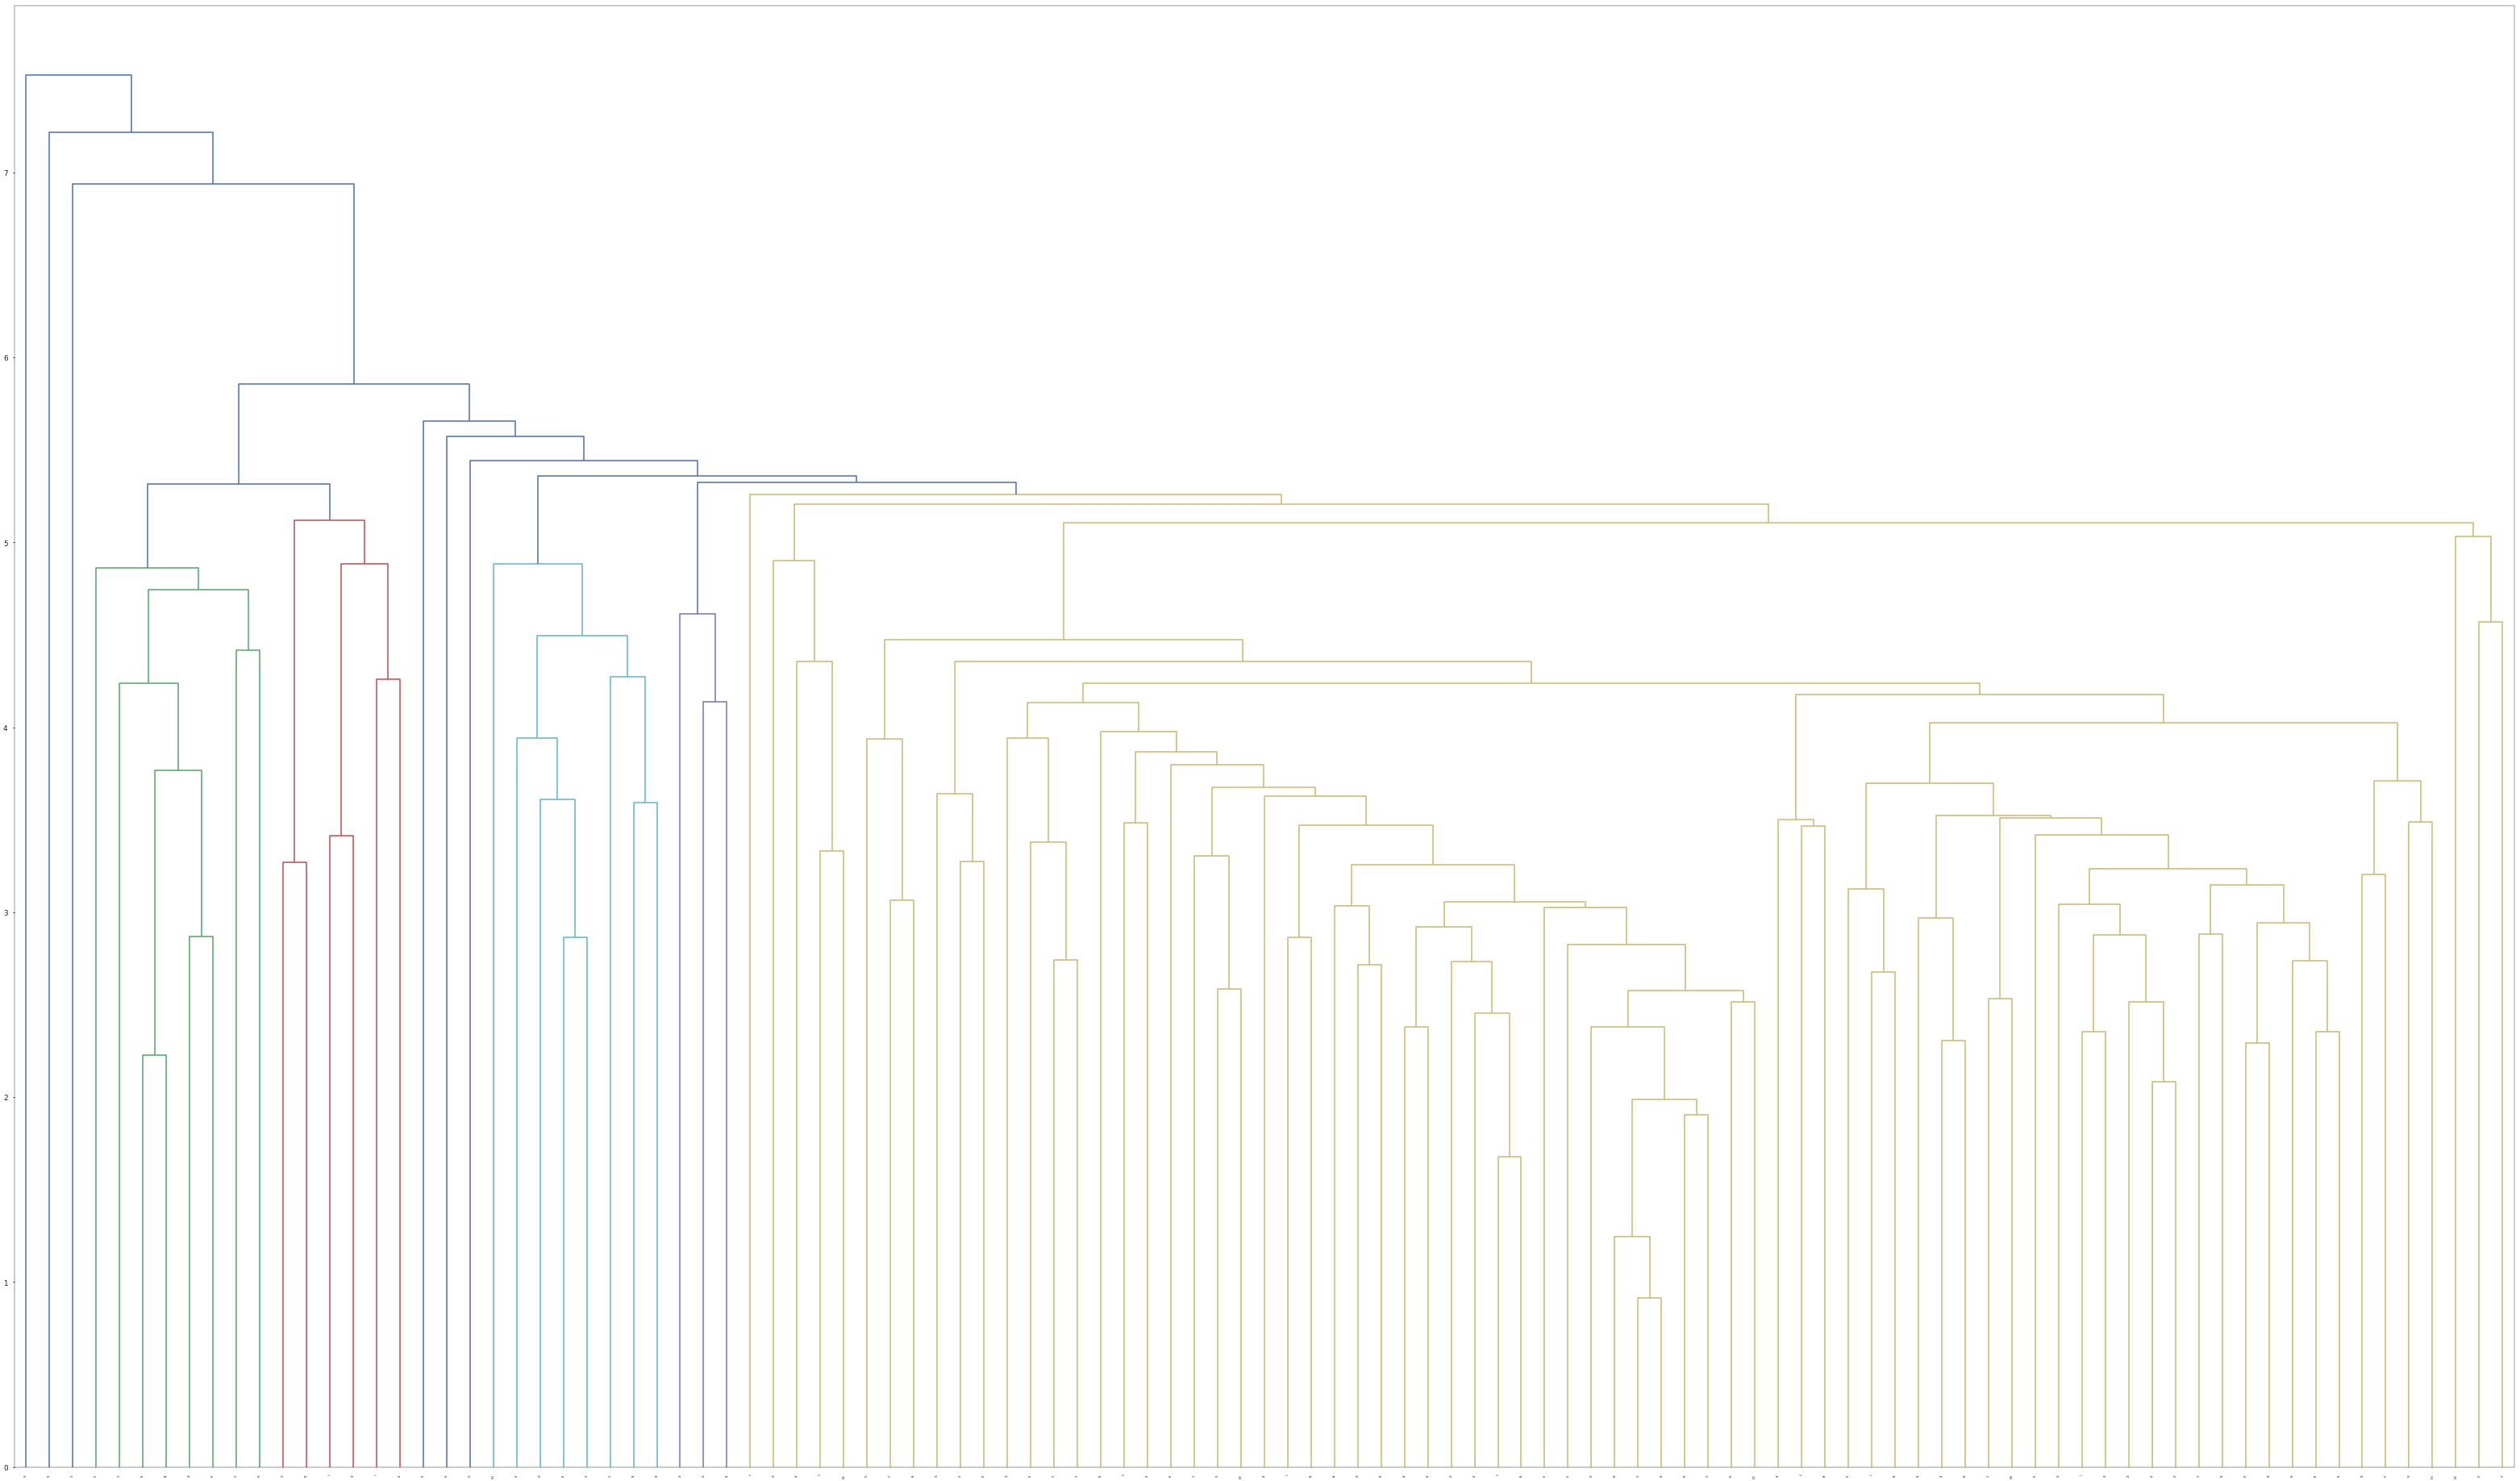

C & C Kitchen,107 E Sangamon Ave,Rantoul,IL
Esquire Lounge,106 N Walnut St,Champaign,IL
V Picasso,122 N Neil St,Champaign,IL
Miga,301 N Neil St, Ste 104,Champaign,IL
Yori Q Korean Grill & Bar,715 S Neil St,Champaign,IL
JP Cool's Bar & Grill,14 N Jefferson St,Mansfield,IL
Casa Real,1204 Bear Ln,Monticello,IL
Flyght Bar and Lounge,142 Lincoln Sq,Urbana,IL
Hybrid Fit Food,410 East University Ave, Ste 101,Champaign,IL
Rantoul Public House,108 N Garrard St,Rantoul,IL
Taffies Cafe,608 E Main St,Mahomet,IL
Wines At the Pines,2860 S Philo Rd, Ste L,Urbana,IL
Bar M,208 W Main St,Urbana,IL
Monarch Brewing,212 South Independence St,Monticello,IL
Courier Cafe,111 N Race St,Urbana,IL
Mid-Summer Lounge,623 E Green St,Champaign,IL
Bacaro,113 N Walnut St,Champaign,IL
Seven Saints,32 E Chester St,Champaign,IL
Charlie's Grub & Suds,106 West 1st St,Homer,IL
Hit Ratio:  0.576923076923
NDCG:  0.90675574985







In [11]:
hr_list = []
ndcg_list = []
for state in valid_state:
    result = recommend_based_on_state(state)
    hr_list.append(result[0])
    ndcg_list.append(result[1])

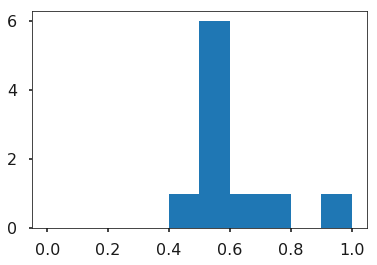

In [12]:
plt.hist([x for x in hr_list if not np.isnan(x)], bins=[x for x in np.arange(0., 1.01, 0.1)])
plt.show()

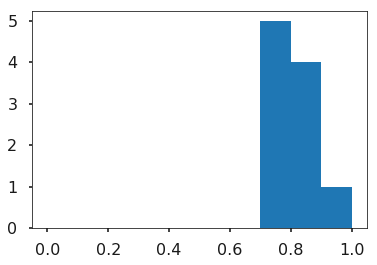

In [13]:
plt.hist([x for x in ndcg_list if not np.isnan(x)], bins=[x for x in np.arange(0., 1.01, 0.1)])
plt.show()

In [14]:
print("Average Hit ratio is : \n", statistics.mean(hr_list))

print("Average NDCG is : \n", statistics.mean(ndcg_list))


Average Hit ratio is : 
 0.610910870026
Average NDCG is : 
 0.822556130389
